imports

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, normalize
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV

from pylab import rcParams

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import regularizers
from tensorflow.keras import layers

import warnings; 
warnings.simplefilter('ignore')

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 999

Read training data and info

In [247]:
data_train = pd.read_csv('train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float64
 3   existence expectancy at birth                                                            3864 non-null   float64
 4   Gross income per capita                                                                  3837 non-null   float64
 5   Income Index                                                  

### Корреляции

In [209]:
data_wrk = data_train[data_train['galactic year'] > 1010025].drop(['galactic year', 'galaxy'], axis=1)
#func_list=[np.power()

print('\n', 'Regular', '\n')
display(abs(data_wrk.corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', 'Squared', '\n')
display(abs((data_wrk ** 2).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', 'Root', '\n')
display(abs((data_wrk ** 1/2).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', '1/x', '\n')
display(abs((data_wrk ** -1).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', 'Log', '\n')
display(abs((np.log(data_wrk)).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', 'Exp', '\n')
display(abs((np.exp(data_wrk)).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))


 Regular 



y                                                                                  1.00
Gender Inequality Index (GII)                                                      0.73
Estimated gross galactic income per capita, female                                 0.71
Interstellar Data Net users, total (% of population)                               0.71
Intergalactic Development Index (IDI), male, Rank                                  0.70
Intergalactic Development Index (IDI), female, Rank                                0.69
Intergalactic Development Index (IDI), Rank                                        0.68
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))   0.67
Intergalactic Development Index (IDI), male                                        0.65
Gross galactic product (GGP) per capita                                            0.65
dtype: float64


 Squared 



y                                                                                  0.93
Interstellar Data Net users, total (% of population)                               0.76
Intergalactic Development Index (IDI), male                                        0.69
Intergalactic Development Index (IDI), female                                      0.68
Expected years of education (galactic years)                                       0.67
Education Index                                                                    0.67
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))   0.67
Estimated gross galactic income per capita, female                                 0.66
Intergalactic Development Index (IDI)                                              0.66
Gender Inequality Index (GII)                                                      0.66
dtype: float64


 Root 



y                                                                                  1.00
Gender Inequality Index (GII)                                                      0.73
Estimated gross galactic income per capita, female                                 0.71
Interstellar Data Net users, total (% of population)                               0.71
Intergalactic Development Index (IDI), male, Rank                                  0.70
Intergalactic Development Index (IDI), female, Rank                                0.69
Intergalactic Development Index (IDI), Rank                                        0.68
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))   0.67
Intergalactic Development Index (IDI), male                                        0.65
Gross galactic product (GGP) per capita                                            0.65
dtype: float64


 1/x 



Gender Inequality Index (GII)                                          0.75
Intergalactic Development Index (IDI), female, Rank                    0.73
Intergalactic Development Index (IDI), male, Rank                      0.73
Intergalactic Development Index (IDI), Rank                            0.72
y                                                                      0.70
Adolescent birth rate (births per 1,000 female creatures ages 15-19)   0.58
Intergalactic Development Index (IDI), male                            0.56
Mortality rate, male grown up (per 1,000 people)                       0.55
Young age (0-14) dependency ratio (per 100 creatures ages 15-64)       0.55
Intergalactic Development Index (IDI)                                  0.54
dtype: float64


 Log 



y                                                                                  0.91
Gender Inequality Index (GII)                                                      0.78
Intergalactic Development Index (IDI), male, Rank                                  0.75
Intergalactic Development Index (IDI), female, Rank                                0.74
Intergalactic Development Index (IDI), Rank                                        0.74
Estimated gross galactic income per capita, female                                 0.67
Gross galactic product (GGP) per capita                                            0.62
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))   0.62
Interstellar Data Net users, total (% of population)                               0.62
Intergalactic Development Index (IDI), male                                        0.61
dtype: float64


 Exp 



y                                                  1.00
Gender Inequality Index (GII)                      0.70
Intergalactic Development Index (IDI), male        0.68
Intergalactic Development Index (IDI), female      0.67
Education Index                                    0.67
Intergalactic Development Index (IDI)              0.66
Income Index                                       0.62
existence expectancy index                         0.57
Mean years of education, female (galactic years)   0.46
Mean years of education, male (galactic years)     0.44
dtype: float64

### Отрицательные значения

Gross income per capita  Population, total (millions)  \
count                 3,837.00                      1,271.00   
mean                 31,633.24                        891.29   
std                  18,736.38                        894.15   
min                    -126.91                       -160.44   
25%                  20,169.12                        599.65   
50%                  26,600.77                        774.11   
75%                  36,898.63                        952.23   
max                 151,072.68                      7,993.32   

       Population, ages 15–64 (millions)  \
count                           1,264.00   
mean                              578.33   
std                               571.04   
min                               -91.29   
25%                               393.56   
50%                               501.29   
75%                               614.06   
max                             5,542.81   

       Population, ages 65 and older (millions)  \
count                                  1,264.00   
mean                                      65.07   
std                                       63.14   
min                                      -23.66   
25%                                       43.45   
50%                                       56.85   
75%                                       69.75   
max                                      649.49   

       Population, under age 5 (millions)  \
count                            1,264.00   
mean                                89.53   
std                                 89.71   
min                                 -2.09   
25%                                 60.16   
50%                                 77.69   
75%                                 95.08   
max                                780.96   

       Employment in agriculture (% of total employment)  \
count                                           1,237.00   
mean                                               54.03   
std                                                25.16   
min                                                -0.68   
25%                                                34.15   
50%                                                49.54   
75%                                                71.63   
max                                               131.09   

       Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)  \
count                                           1,219.00                                 
mean                                               18.80                                 
std                                                11.51                                 
min                                                -1.32                                 
25%                                                11.91                                 
50%                                                15.34                                 
75%                                                21.36                                 
max                                                72.43                                 

       Gross galactic product (GGP), total  \
count                             1,202.00   
mean                              7,749.98   
std                               7,167.78   
min                                -933.22   
25%                               5,479.46   
50%                               7,130.47   
75%                               8,786.80   
max                             112,391.32   

       Outer Galaxies direct investment, net inflows (% of GGP)  \
count                                           1,169.00          
mean                                               18.34          
std                                                15.38          
min                                                -5.27          
25%                                                13.02         

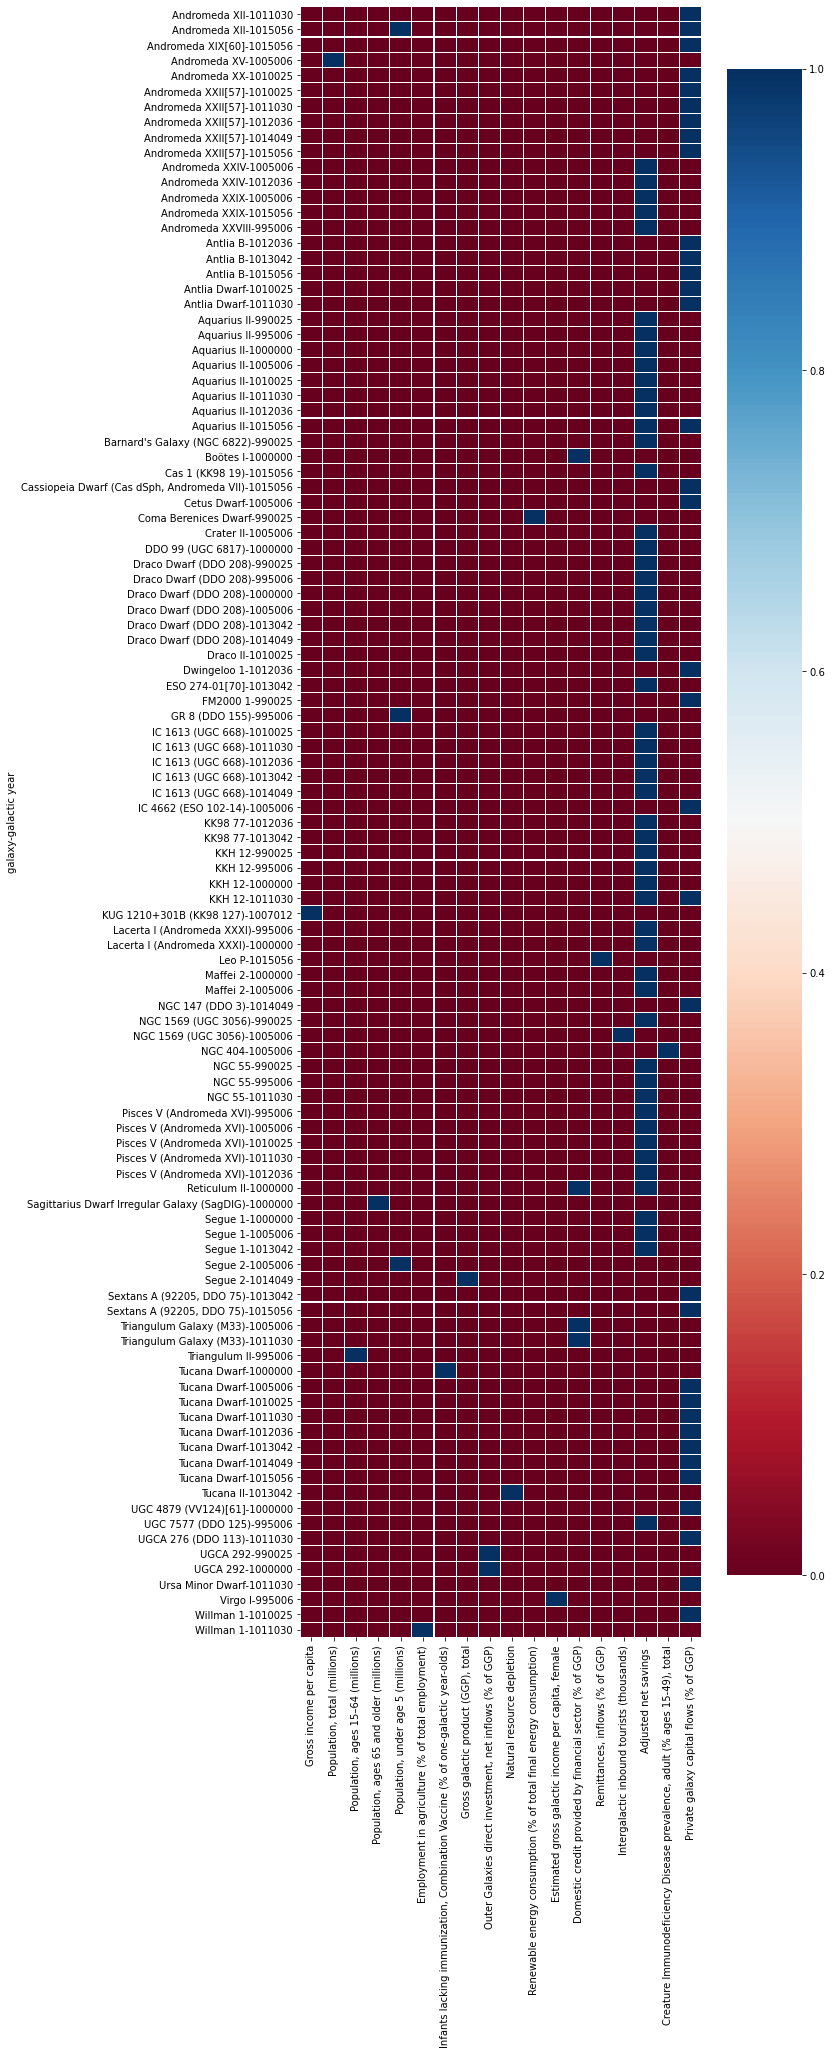

In [210]:
rcParams['figure.figsize'] = 9, 30
data_train_subzero_cols = [x for x in data_train.columns if \
                           (data_train[x].dtype in ['float64', 'int64'] and data_train[x].min() < 0)]
data_train_subzero = data_train[(data_train.drop('galaxy', axis=1) < 0).any(axis=1)][['galaxy', 'galactic year'] + data_train_subzero_cols]
sns.heatmap(data_train_subzero.set_index(['galaxy', 'galactic year']).sort_index() < 0, cmap="RdBu", linewidths=0.05)
display(data_train[data_train_subzero_cols].describe(include='all'))


### Значения NaN

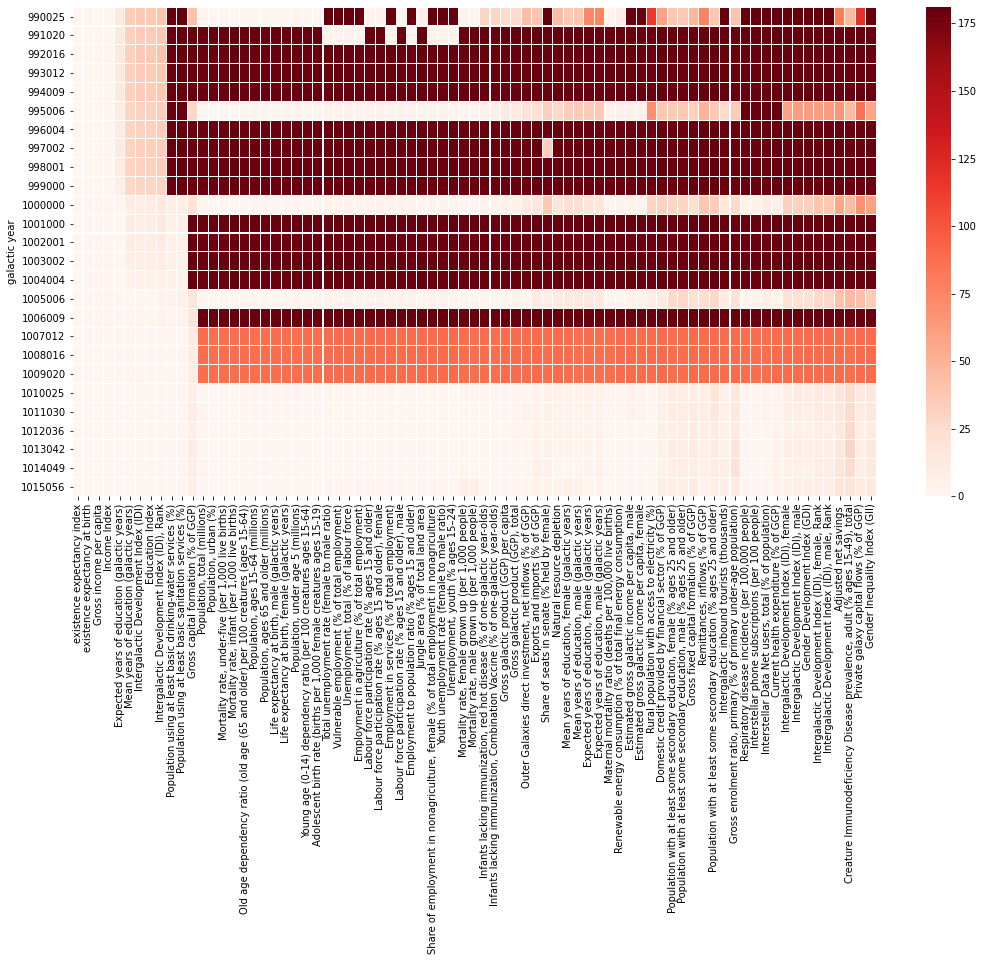

In [211]:
# Кол-во стран с незаполненными атрибутами по года
rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data_train.columns if any((data_train[x] != data_train[x]))]
sns.heatmap((data_train[['galactic year']].join(data_train[cols_nan] != data_train[cols_nan])).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);
# data_train['galaxy'] == 'Andromeda XV'
# data_train.loc[data_train['galaxy'] == 'Andromeda XV'][['galactic year', 'galaxy', 'Population, total (millions)', 'y']]#.describe()

## Анализ данных

Функция для анализа данных:

In [239]:

def data_desc(data, cols=[], start_col=0, n_cols=10):
    """Description for data
    data - Dataset;
    cols - Columns for subset;
    start_col - Start No. of column subset;
    n_cols - Number of columns in subset. Default 10 for good screen fitting;
    """
    if not cols:
        i = start_col
        cols = list(data.drop(['galaxy', 'galactic year'], axis=1).columns[start_col:min(data.shape[1], start_col + n_cols)])
    print('Data head:', '\n')
    display(data[cols].head(10))
    print('Data description:', '\n')
    display(data[cols].describe(include='all'))
    print('Data fullness:', '\n')
    rcParams['figure.figsize'] = 18, 9
    sns.heatmap(data.groupby(['galactic year'])[['galaxy'] + cols].count(), cmap="Reds", linewidths=0.05, annot=True, fmt='d');
    plt.show()
    #display(data.groupby(['galactic year'])[['galaxy'] + cols].count())
    print('Data distribution:', '\n')
    rcParams['figure.figsize'] = 18, 9
    data[cols].hist();
    plt.show()
    fig, ax = plt.subplots(4, 3, figsize=(16, 12))
    for i, c in enumerate(cols):
        data_wrk = data[c]
        qqplot(data_wrk, line='s', ax=ax[i//3, i%3])
    plt.show()
    print('Data correlation:', '\n')
    display(data[cols].corrwith(data['y']))
    print()
    sns.heatmap(data[cols + ['y']].corr(), cmap="RdYlBu", vmin=-1, vmax=1)
    print('\n', '-' * 50, '\n')

Для первых 10 признаков:

Data head: 



existence expectancy index  existence expectancy at birth  \
0                        0.63                          63.13   
1                        0.82                          81.00   
2                        0.66                          59.57   
3                        0.56                          52.33   
4                        0.99                          81.80   
5                        0.82                          63.89   
6                        0.66                          68.56   
7                        0.95                          75.69   
8                        0.66                          61.34   
9                        0.66                          62.55   

   Gross income per capita  Income Index  \
0                27,109.23          0.65   
1                30,166.79          0.85   
2                 8,441.71          0.50   
3                      nan           nan   
4                81,033.96          1.13   
5                28,409.06          0.67   
6                25,648.33          0.75   
7                20,935.54          0.95   
8                18,231.03          0.83   
9                16,196.13          0.68   

   Expected years of education (galactic years)  \
0                                          8.24   
1                                         10.67   
2                                          8.84   
3                                           nan   
4                                         13.80   
5                                         14.06   
6                                         15.43   
7                                         14.86   
8                                         15.17   
9                                         12.94   

   Mean years of education (galactic years)  \
0                                       nan   
1                                      4.74   
2                                      5.58   
3                                       nan   
4                                     13.19   
5                                      9.98   
6                                     10.02   
7                                       nan   
8                                      6.94   
9                                      6.53   

   Intergalactic Development Index (IDI)  Education Index  \
0                                    nan              nan   
1                                   0.83             0.47   
2                                   0.47             0.36   
3                                    nan              nan   
4                                   0.91             0.92   
5                                   0.82             0.80   
6                                   0.66             0.74   
7                                    nan              nan   
8                                   0.73             0.65   
9                                   0.56             0.48   

   Intergalactic Development Index (IDI), Rank  \
0                                          nan   
1                                       152.52   
2                                       209.81   
3                                          nan   
4                                        71.89   
5                                       121.84   
6                                       149.57   
7                                          nan   
8                                       168.49   
9                                       154.10   

   Population using at least basic drinking-water services (%)  
0                                                nan            
1                                                nan            
2                                                nan            
3                                                nan            
4                                                nan            
5                                                nan            
6                                                nan   

Data description: 



existence expectancy index  existence expectancy at birth  \
count                    3,864.00                       3,864.00   
mean                         0.87                          76.80   
std                          0.16                          10.46   
min                          0.23                          34.24   
25%                          0.76                          69.96   
50%                          0.91                          79.00   
75%                          0.99                          84.56   
max                          1.25                         100.21   

       Gross income per capita  Income Index  \
count                 3,837.00      3,837.00   
mean                 31,633.24          0.83   
std                  18,736.38          0.19   
min                    -126.91          0.29   
25%                  20,169.12          0.68   
50%                  26,600.77          0.83   
75%                  36,898.63          0.97   
max                 151,072.68          1.36   

       Expected years of education (galactic years)  \
count                                      3,732.00   
mean                                          14.72   
std                                            3.61   
min                                            3.80   
25%                                           12.59   
50%                                           14.94   
75%                                           17.12   
max                                           26.96   

       Mean years of education (galactic years)  \
count                                  3,502.00   
mean                                      10.28   
std                                        3.32   
min                                        1.93   
25%                                        7.65   
50%                                       10.39   
75%                                       12.88   
max                                       19.06   

       Intergalactic Development Index (IDI)  Education Index  \
count                               3,474.00         3,474.00   
mean                                    0.80             0.75   
std                                     0.18             0.20   
min                                     0.27             0.19   
25%                                     0.67             0.60   
50%                                     0.82             0.76   
75%                                     0.94             0.89   
max                                     1.23             1.27   

       Intergalactic Development Index (IDI), Rank  \
count                                     3,432.00   
mean                                        135.13   
std                                          52.45   
min                                           9.93   
25%                                          92.26   
50%                                         135.91   
75%                                         175.30   
max                                         278.79   

       Population using at least basic drinking-water services (%)  
count                                           2,021.00            
mean                                              101.89            
std                                                20.32            
min                                                33.14            
25%                                                89.47            
50%                                               108.42            
75%                                               116.90            
max                                               136.32

Data fullness: 



galaxy  existence expectancy index  \
galactic year                                       
990025            181                         180   
991020            180                         180   
992016            180                         180   
993012            180                         180   
994009            180                         180   
995006            180                         180   
996004            180                         180   
997002            180                         180   
998001            180                         180   
999000            180                         180   
1000000           180                         180   
1001000           180                         180   
1002001           180                         180   
1003002           180                         180   
1004004           180                         180   
1005006           180                         180   
1006009           180                         180   
1007012            90                          90   
1008016            90                          90   
1009020            90                          90   
1010025            90                          90   
1011030            90                          90   
1012036            90                          90   
1013042            89                          89   
1014049            88                          88   
1015056            87                          87   

               existence expectancy at birth  Gross income per capita  \
galactic year                                                           
990025                                   180                      179   
991020                                   180                      178   
992016                                   180                      178   
993012                                   180                      178   
994009                                   180                      178   
995006                                   180                      178   
996004                                   180                      178   
997002                                   180                      178   
998001                                   180                      178   
999000                                   180                      178   
1000000                                  180                      179   
1001000                                  180                      179   
1002001                                  180                      179   
1003002                                  180                      179   
1004004                                  180                      179   
1005006                                  180                      179   
1006009                                  180                      179   
1007012                                   90                       89   
1008016                                   90                       90   
1009020                                   90                       90   
1010025                                   90                       90   
1011030                                   90                       90   
1012036                                   90                       90   
1013042                                   89                       89   
1014049                                   88                       88   
1015056                                   87                       87   

               Income Index  Expected years of education (galactic years)  \
galactic year                                                               
990025                  179                                           167   
991020                  178                                           167   
992016                  178                                           166   
993012                  178                                           167   
994009                 

Data distribution: 



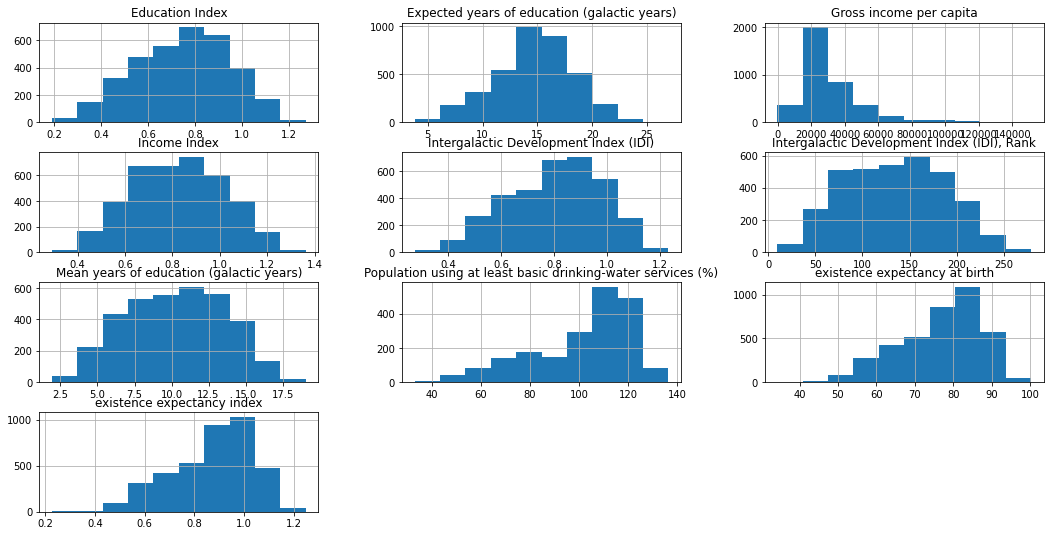

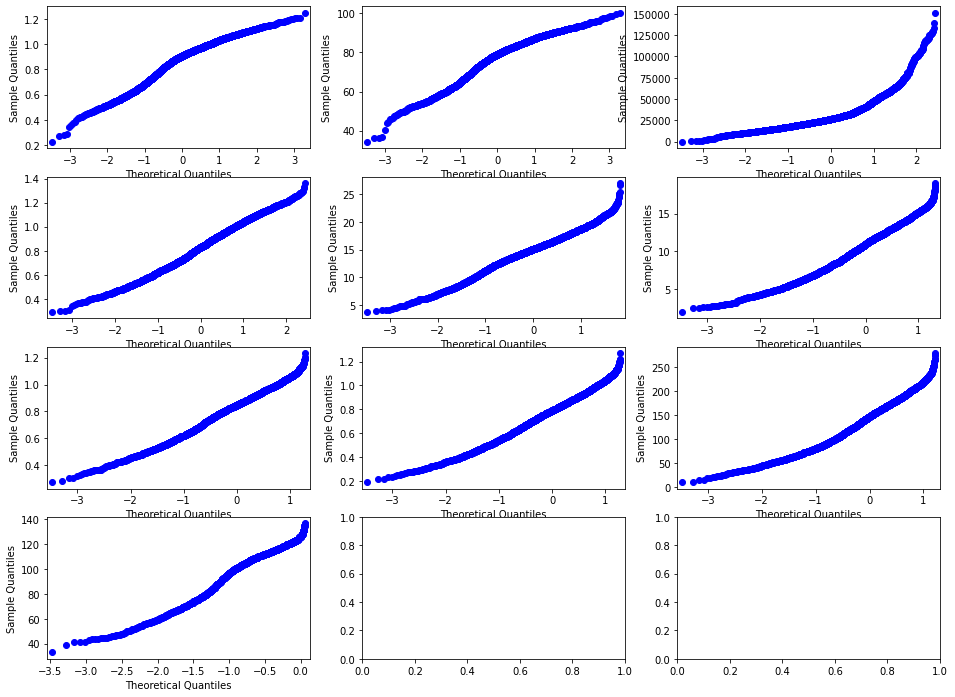

Data correlation: 



existence expectancy index                                     0.55
existence expectancy at birth                                  0.56
Gross income per capita                                        0.51
Income Index                                                   0.58
Expected years of education (galactic years)                   0.58
Mean years of education (galactic years)                       0.58
Intergalactic Development Index (IDI)                          0.63
Education Index                                                0.61
Intergalactic Development Index (IDI), Rank                   -0.68
Population using at least basic drinking-water services (%)    0.43
dtype: float64



 -------------------------------------------------- 



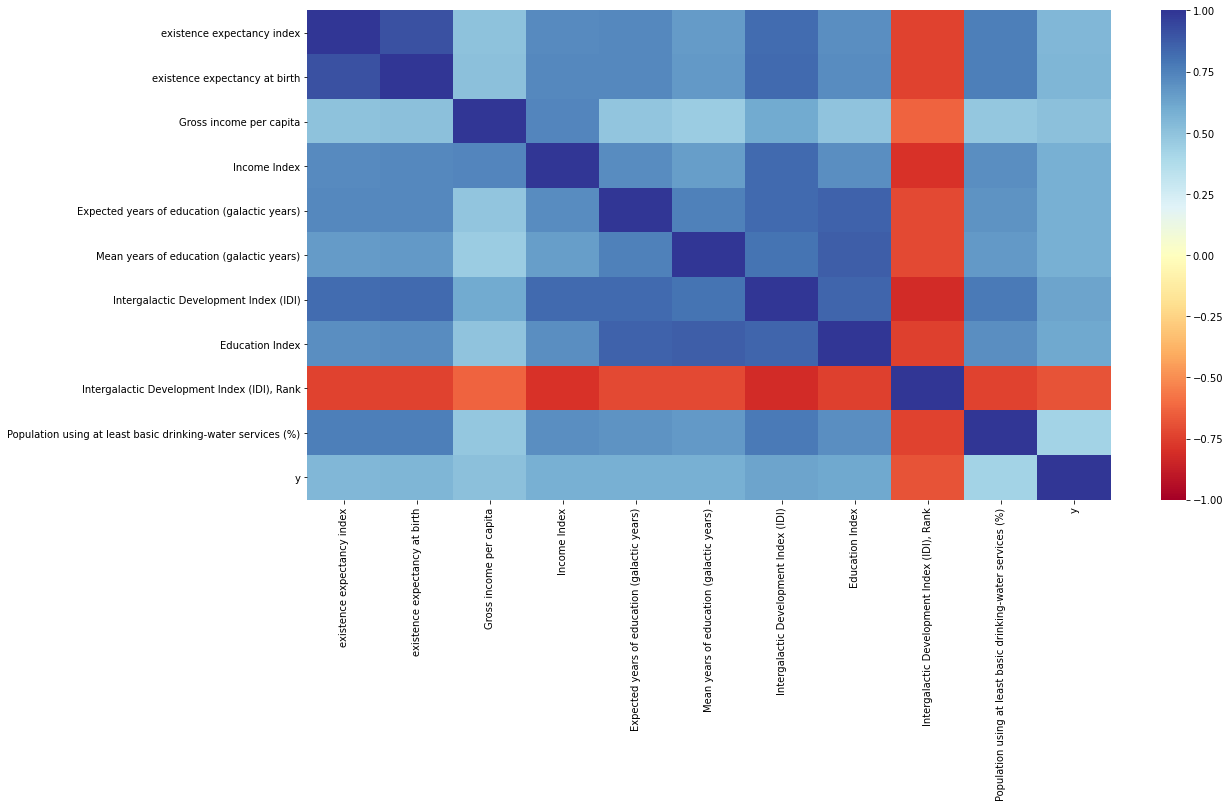

In [230]:
data_desc(data_train, start_col=0)

10 - 20:

Data head: 



Population using at least basic sanitation services (%)  \
0                                                nan         
1                                                nan         
2                                                nan         
3                                                nan         
4                                                nan         
5                                                nan         
6                                                nan         
7                                                nan         
8                                                nan         
9                                                nan         

   Gross capital formation (% of GGP)  Population, total (millions)  \
0                               38.31                        681.84   
1                               36.26                        423.97   
2                               18.09                        285.57   
3                                 nan                        327.20   
4                               34.50                        633.80   
5                               31.22                        821.71   
6                               21.99                        855.75   
7                                 nan                        999.83   
8                               20.36                        468.69   
9                               21.78                        913.59   

   Population, urban (%)  Mortality rate, under-five (per 1,000 live births)  \
0                  22.13                                             150.26    
1                  89.29                                             117.07    
2                  57.49                                             226.52    
3                  47.79                                             279.00    
4                 103.56                                              28.36    
5                  54.31                                              94.32    
6                  82.04                                             155.49    
7                  78.38                                             129.08    
8                  85.31                                             145.10    
9                  47.23                                             203.63    

   Mortality rate, infant (per 1,000 live births)  \
0                                          129.84   
1                                           61.82   
2                                          134.56   
3                                          193.23   
4                                           51.10   
5                                           70.03   
6                                           98.29   
7                                           65.82   
8                                           84.75   
9                                          119.40   

   Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))  \
0                                              12.40                                  
1                                              13.05                                  
2                                              15.96                                  
3                                              12.94                                  
4                                              25.52                                  
5                                              12.00                                  
6                                              14.49                                  
7                                              15.81                                  
8                                               9.19                                  
9                                              18.68                                  

   Population, ages 15–64 (millions)  \
0                             490.45   
1                             560.5

Data description: 



Population using at least basic sanitation services (%)  \
count                                           2,015.00         
mean                                               99.94         
std                                                32.36         
min                                                10.61         
25%                                                73.45         
50%                                               110.27         
75%                                               125.64         
max                                               161.27         

       Gross capital formation (% of GGP)  Population, total (millions)  \
count                            1,502.00                      1,271.00   
mean                                31.86                        891.29   
std                                  8.48                        894.15   
min                                  2.49                       -160.44   
25%                                 27.18                        599.65   
50%                                 31.22                        774.11   
75%                                 36.03                        952.23   
max                                 72.31                      7,993.32   

       Population, urban (%)  \
count               1,271.00   
mean                   77.23   
std                    24.20   
min                    20.78   
25%                    57.48   
50%                    77.51   
75%                    97.68   
max                   129.91   

       Mortality rate, under-five (per 1,000 live births)  \
count                                           1,271.00    
mean                                               97.40    
std                                                55.72    
min                                                 9.72    
25%                                                58.15    
50%                                                79.13    
75%                                               123.57    
max                                               379.42    

       Mortality rate, infant (per 1,000 live births)  \
count                                        1,259.00   
mean                                            64.90   
std                                             34.00   
min                                             12.79   
25%                                             39.37   
50%                                             55.48   
75%                                             83.31   
max                                            208.50   

       Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))  \
count                                           1,264.00                                  
mean                                               18.90                                  
std                                                 7.54                                  
min                                                 4.30                                  
25%                                                13.50                                  
50%                                                16.69                                  
75%                                                23.29                                  
max                                                52.22                                  

       Population, ages 15–64 (millions)  \
count                           1,264.00   
mean                              578.33   
std                               571.04   
min                               -91.29   
25%                               393.56   
50%                               501.29   
75%                               614.06   
max                             5,542.81   

       Population, ages 65 and older (millions)  \
count                                  1,264.00   
mean                                      65.07   
std          

Data fullness: 



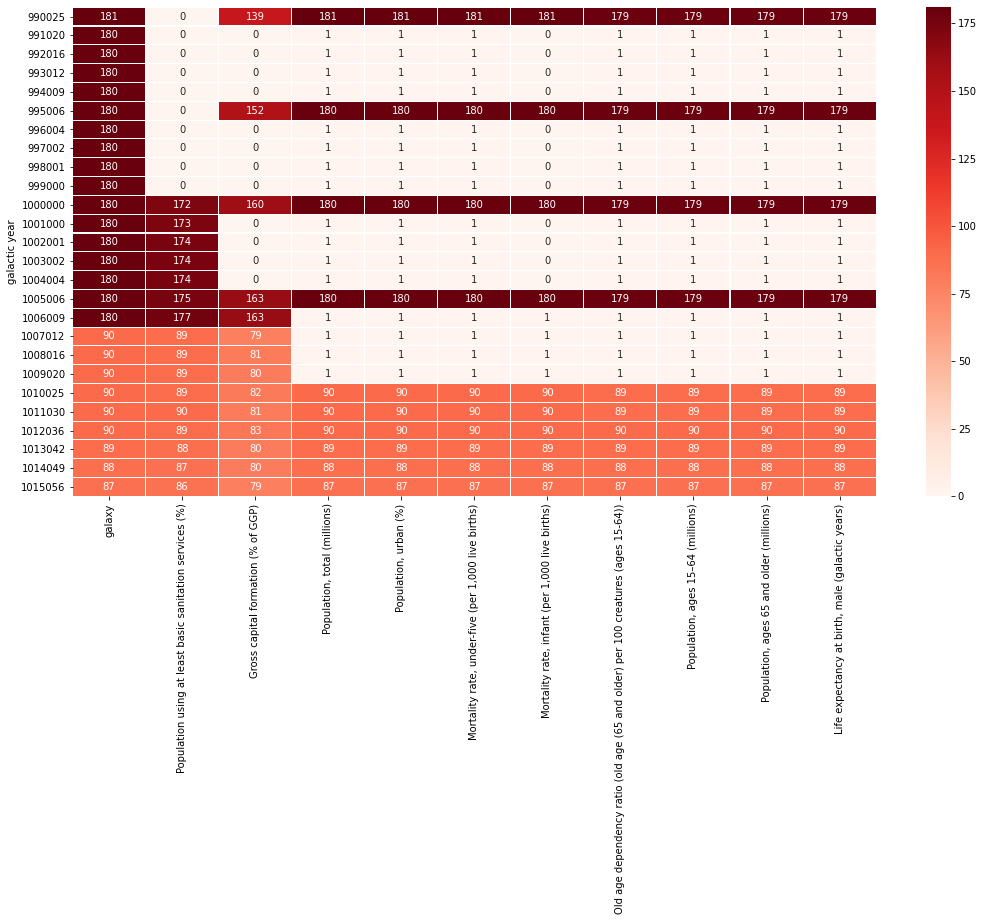

Data distribution: 



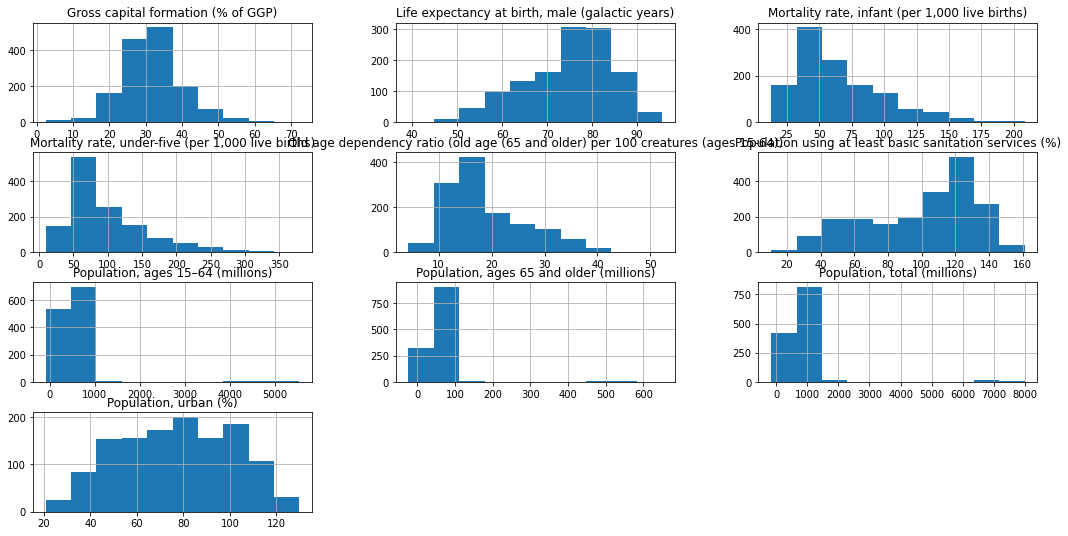

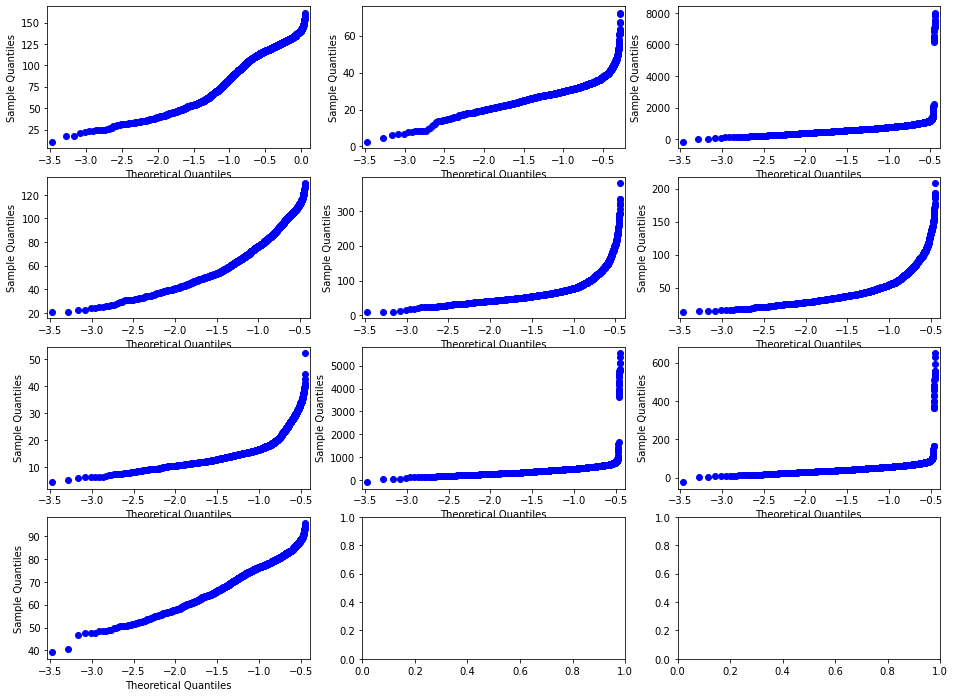

Data correlation: 



Population using at least basic sanitation services (%)                             0.48
Gross capital formation (% of GGP)                                                 -0.01
Population, total (millions)                                                       -0.06
Population, urban (%)                                                               0.48
Mortality rate, under-five (per 1,000 live births)                                 -0.39
Mortality rate, infant (per 1,000 live births)                                     -0.43
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))    0.68
Population, ages 15–64 (millions)                                                  -0.07
Population, ages 65 and older (millions)                                           -0.05
Life expectancy at birth, male (galactic years)                                     0.54
dtype: float64



 -------------------------------------------------- 



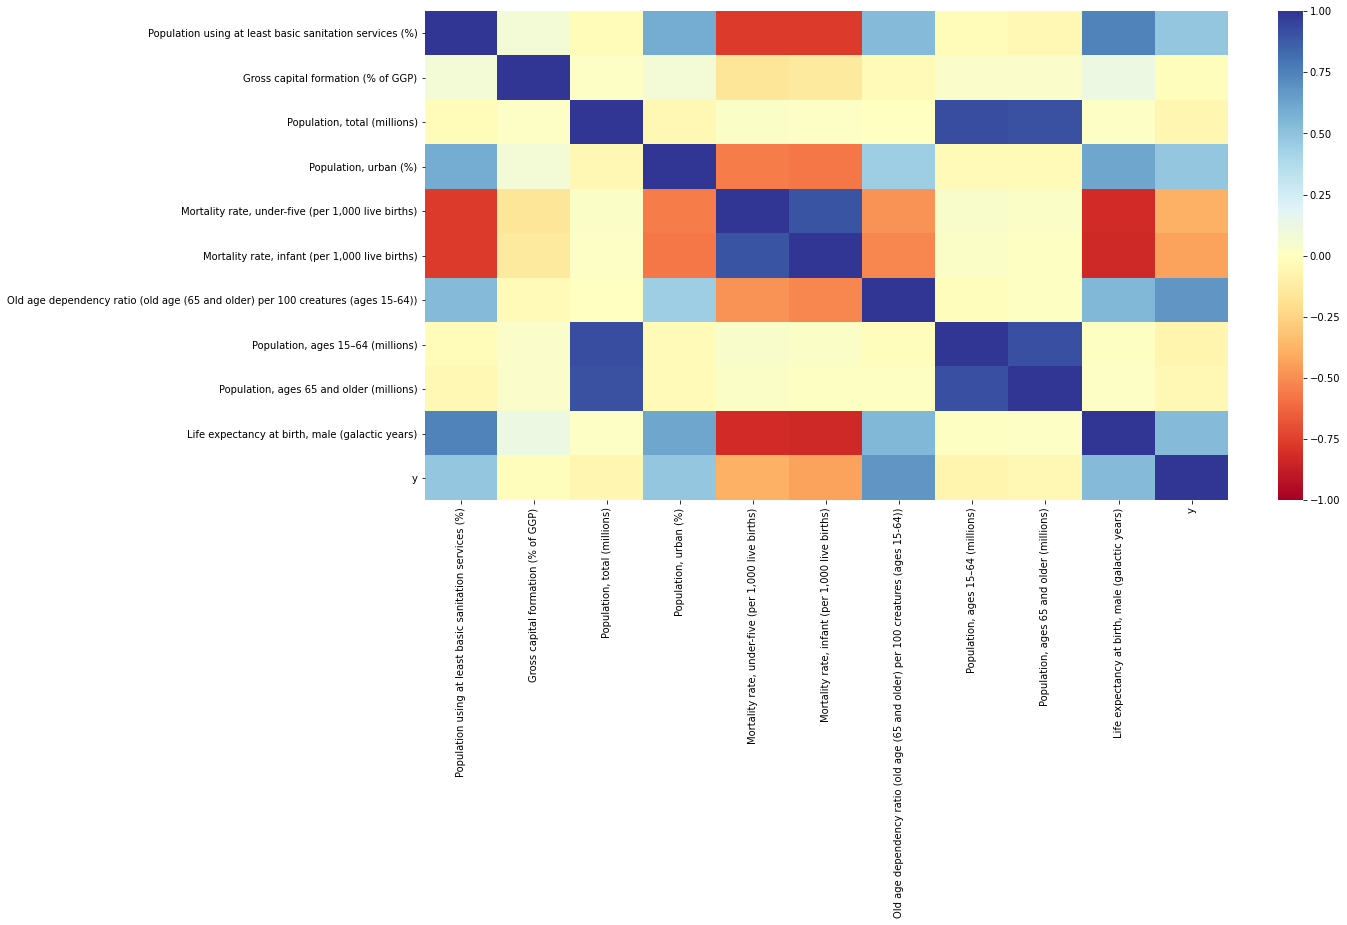

In [240]:
data_desc(data_train, start_col=10)

20-30:

Data head: 



Life expectancy at birth, female (galactic years)  \
0                                              69.83   
1                                              76.75   
2                                              59.15   
3                                              54.93   
4                                              84.71   
5                                              82.34   
6                                              66.95   
7                                              85.91   
8                                              61.67   
9                                              68.95   

   Population, under age 5 (millions)  \
0                               46.02   
1                               40.17   
2                               91.09   
3                               92.73   
4                               71.49   
5                               25.33   
6                               64.26   
7                               87.29   
8                               90.52   
9                               71.74   

   Young age (0-14) dependency ratio (per 100 creatures ages 15-64)  \
0                                              98.22                  
1                                              88.32                  
2                                             114.16                  
3                                              97.65                  
4                                              53.84                  
5                                             108.56                  
6                                              97.01                  
7                                              85.28                  
8                                             113.11                  
9                                             102.73                  

   Adolescent birth rate (births per 1,000 female creatures ages 15-19)  \
0                                             174.62                      
1                                             109.89                      
2                                             230.57                      
3                                             198.97                      
4                                              61.01                      
5                                             170.18                      
6                                             168.45                      
7                                             157.86                      
8                                             151.60                      
9                                             102.57                      

   Total unemployment rate (female to male ratio)  \
0                                             nan   
1                                             nan   
2                                             nan   
3                                             nan   
4                                             nan   
5                                             nan   
6                                             nan   
7                                             nan   
8                                             nan   
9                                             nan   

   Vulnerable employment (% of total employment)  \
0                                            nan   
1                                            nan   
2                                            nan   
3                                            nan   
4                                            nan   
5                                            nan   
6                                            nan   
7                                            nan   
8                                            nan   
9                                            nan   

   Unemployment, total (% of labour force)  \
0                                      nan   
1                                      nan   
2                              

Data description: 



Life expectancy at birth, female (galactic years)  \
count                                           1,264.00   
mean                                               80.16   
std                                                10.67   
min                                                40.94   
25%                                                72.91   
50%                                                82.65   
75%                                                88.03   
max                                               101.68   

       Population, under age 5 (millions)  \
count                            1,264.00   
mean                                89.53   
std                                 89.71   
min                                 -2.09   
25%                                 60.16   
50%                                 77.69   
75%                                 95.08   
max                                780.96   

       Young age (0-14) dependency ratio (per 100 creatures ages 15-64)  \
count                                           1,264.00                  
mean                                               78.22                  
std                                                25.53                  
min                                                11.62                  
25%                                                56.59                  
50%                                                75.23                  
75%                                                99.88                  
max                                               137.20                  

       Adolescent birth rate (births per 1,000 female creatures ages 15-19)  \
count                                           1,252.00                      
mean                                              113.36                      
std                                                52.08                      
min                                                14.34                      
25%                                                72.36                      
50%                                               103.81                      
75%                                               145.08                      
max                                               289.81                      

       Total unemployment rate (female to male ratio)  \
count                                        1,237.00   
mean                                             2.77   
std                                              1.34   
min                                              0.93   
25%                                              2.19   
50%                                              2.59   
75%                                              3.08   
max                                             29.66   

       Vulnerable employment (% of total employment)  \
count                                       1,237.00   
mean                                           68.64   
std                                            29.78   
min                                            11.66   
25%                                            43.71   
50%                                            64.27   
75%                                            92.38   
max                                           143.93   

       Unemployment, total (% of labour force)  \
count                                 1,237.00   
mean                                     14.61   
std                                       6.74   
min                                       1.96   
25%                                       9.83   
50%                                      13.28   
75%                                      17.70   
max                                      44.85   

       Employment in agriculture (% of total employment)  \
count                                           1,237.00   
mean                                               54.03   
std                   

Data fullness: 



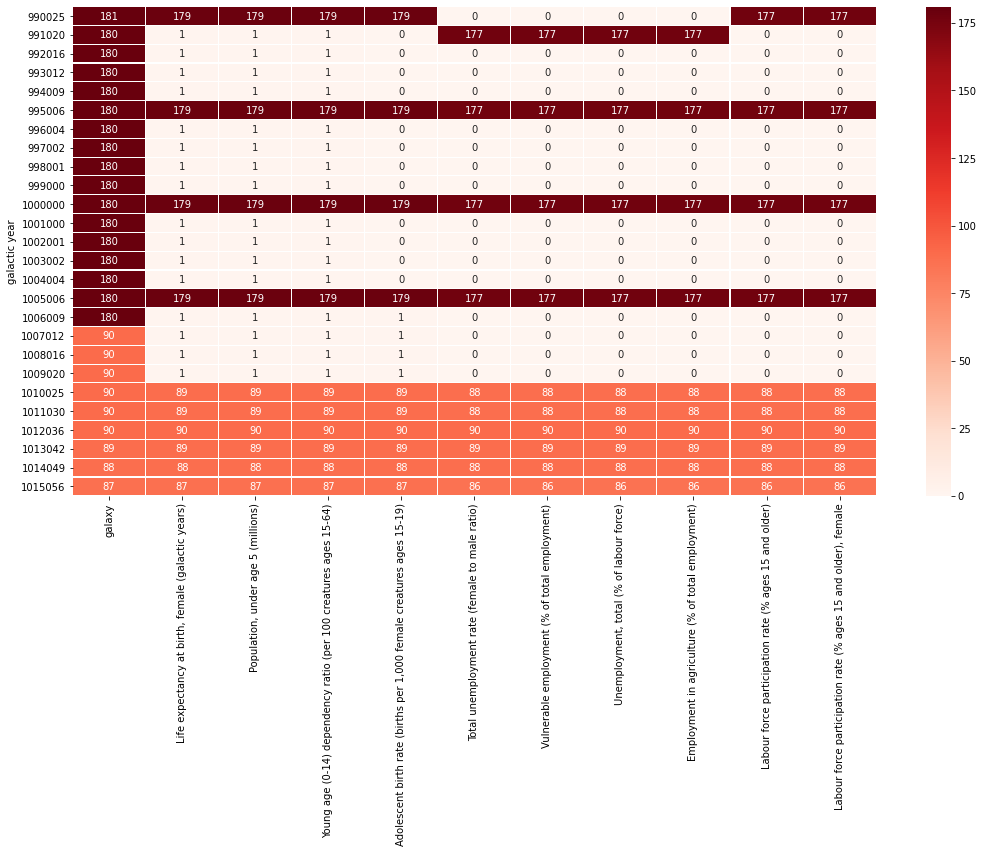

Data distribution: 



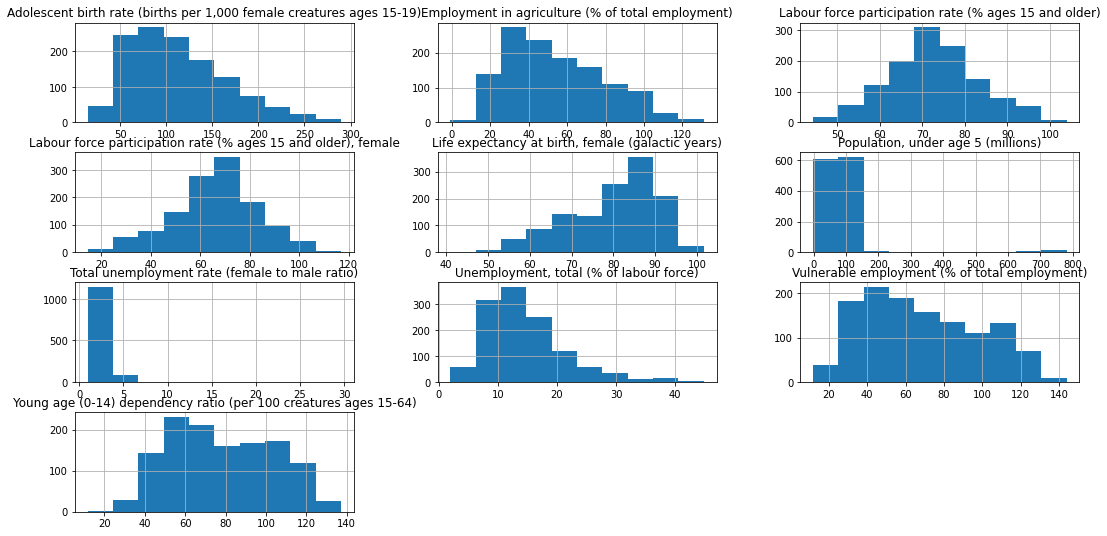

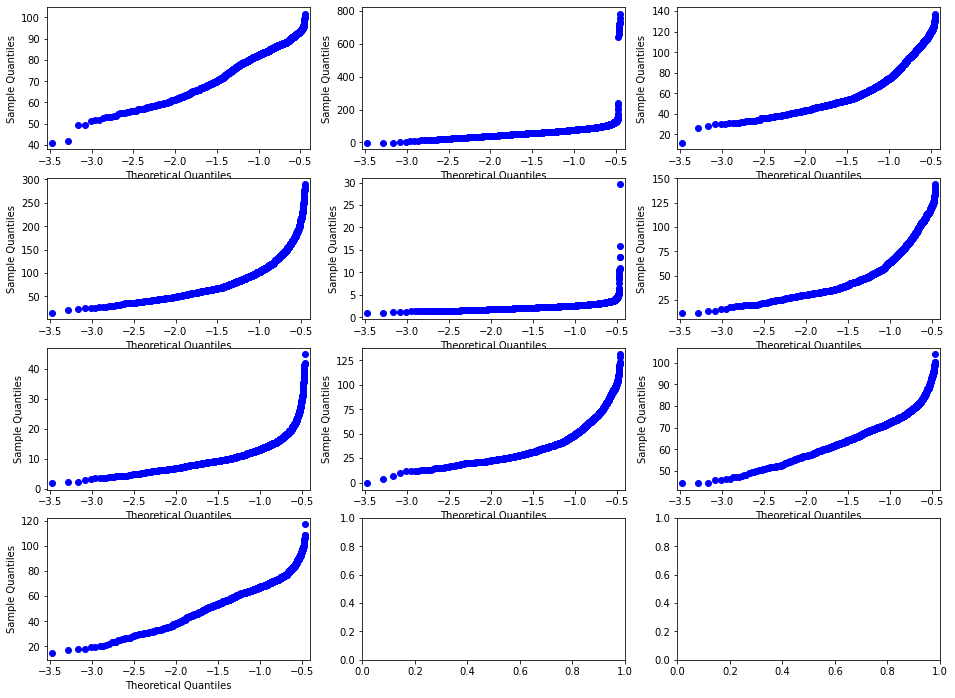

Data correlation: 



Life expectancy at birth, female (galactic years)                       0.52
Population, under age 5 (millions)                                     -0.07
Young age (0-14) dependency ratio (per 100 creatures ages 15-64)       -0.53
Adolescent birth rate (births per 1,000 female creatures ages 15-19)   -0.49
Total unemployment rate (female to male ratio)                         -0.10
Vulnerable employment (% of total employment)                          -0.50
Unemployment, total (% of labour force)                                -0.03
Employment in agriculture (% of total employment)                      -0.47
Labour force participation rate (% ages 15 and older)                  -0.05
Labour force participation rate (% ages 15 and older), female           0.07
dtype: float64



 -------------------------------------------------- 



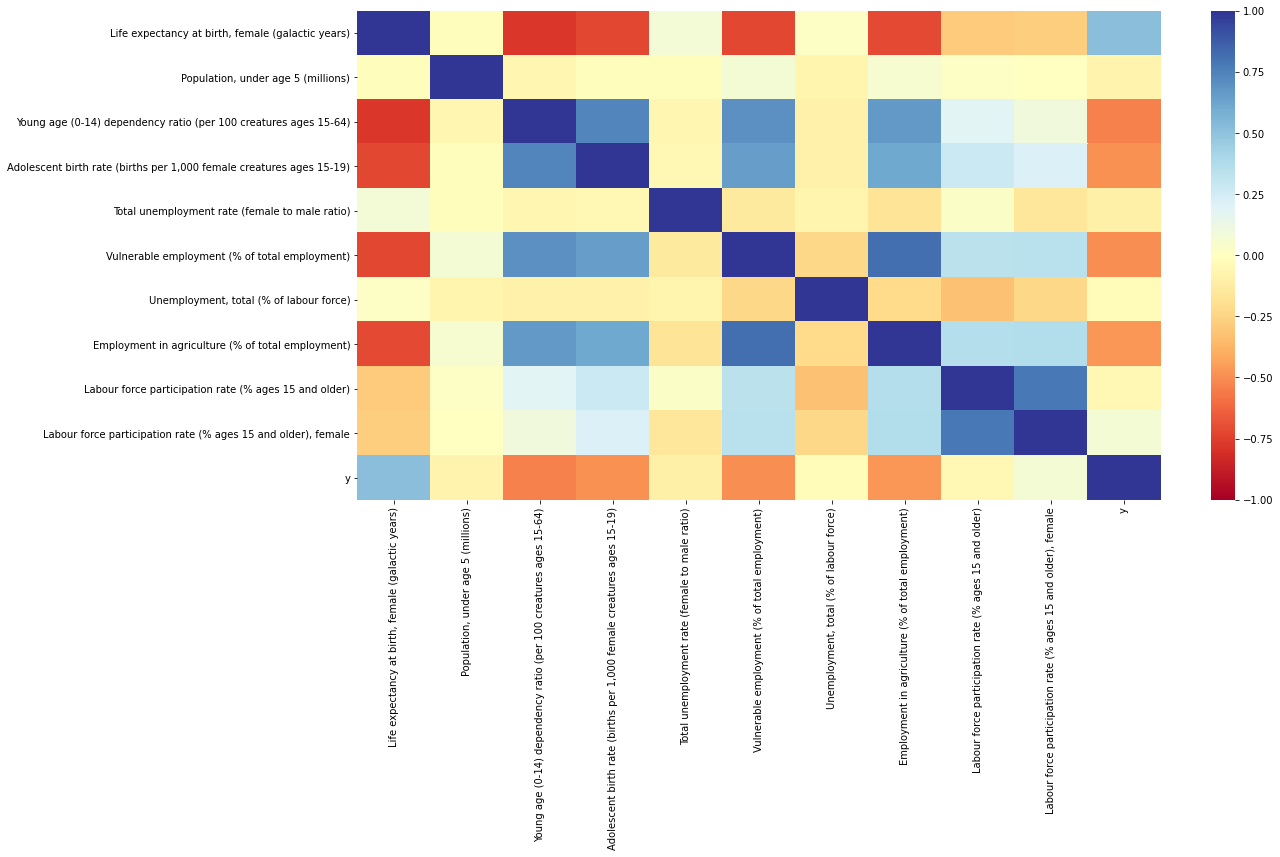

In [241]:
data_desc(data_train, start_col=20)

30-40:

Data head: 



Employment in services (% of total employment)  \
0                                             nan   
1                                             nan   
2                                             nan   
3                                             nan   
4                                             nan   
5                                             nan   
6                                             nan   
7                                             nan   
8                                             nan   
9                                             nan   

   Labour force participation rate (% ages 15 and older), male  \
0                                              85.85             
1                                              93.53             
2                                              95.04             
3                                              86.31             
4                                              76.67             
5                                              72.24             
6                                              95.12             
7                                              69.03             
8                                              79.18             
9                                              86.01             

   Employment to population ratio (% ages 15 and older)  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      
6                                                nan      
7                                                nan      
8                                                nan      
9                                                nan      

   Jungle area (% of total land area)  \
0                               73.17   
1                               35.59   
2                               48.89   
3                                 nan   
4                                 nan   
5                               25.30   
6                               77.54   
7                              127.50   
8                               89.40   
9                               28.69   

   Share of employment in nonagriculture, female (% of total employment in nonagriculture)  \
0                                                nan                                         
1                                                nan                                         
2                                                nan                                         
3                                                nan                                         
4                                                nan                                         
5                                                nan                                         
6                                                nan                                         
7                                                nan                                         
8                                                nan                                         
9                                                nan                                         

   Youth unemployment rate (female to male ratio)  \
0                                             nan   
1                                             nan   
2                                             nan   
3                                             nan   
4                                             nan   
5                                             nan   
6                                             nan   
7                                             nan   
8                                             nan   
9                        

Data description: 



Employment in services (% of total employment)  \
count                                        1,237.00   
mean                                            68.32   
std                                             19.27   
min                                             13.82   
25%                                             54.67   
50%                                             69.40   
75%                                             83.13   
max                                            110.76   

       Labour force participation rate (% ages 15 and older), male  \
count                                           1,237.00             
mean                                               82.92             
std                                                 9.25             
min                                                47.24             
25%                                                76.72             
50%                                                83.56             
75%                                                89.18             
max                                               106.82             

       Employment to population ratio (% ages 15 and older)  \
count                                           1,237.00      
mean                                               68.95      
std                                                12.13      
min                                                33.40      
25%                                                61.09      
50%                                                69.39      
75%                                                76.24      
max                                               103.96      

       Jungle area (% of total land area)  \
count                            1,234.00   
mean                                55.02   
std                                 24.80   
min                                  7.13   
25%                                 34.48   
50%                                 53.32   
75%                                 71.53   
max                                134.47   

       Share of employment in nonagriculture, female (% of total employment in nonagriculture)  \
count                                           1,237.00                                         
mean                                               50.16                                         
std                                                11.87                                         
min                                                13.02                                         
25%                                                45.28                                         
50%                                                52.66                                         
75%                                                57.67                                         
max                                                79.49                                         

       Youth unemployment rate (female to male ratio)  \
count                                        1,236.00   
mean                                             2.26   
std                                              0.81   
min                                              0.61   
25%                                              1.83   
50%                                              2.16   
75%                                              2.57   
max                                             14.80   

       Unemployment, youth (% ages 15–24)  \
count                            1,236.00   
mean                                29.63   
std                                 12.94   
min                                  4.48   
25%                                 20.47   
50%                                 26.70   
75%                                 36.43   
max                                 84.10   

       Mortality rate, female grown up (per 1,000 people)  \
count                   

Data fullness: 



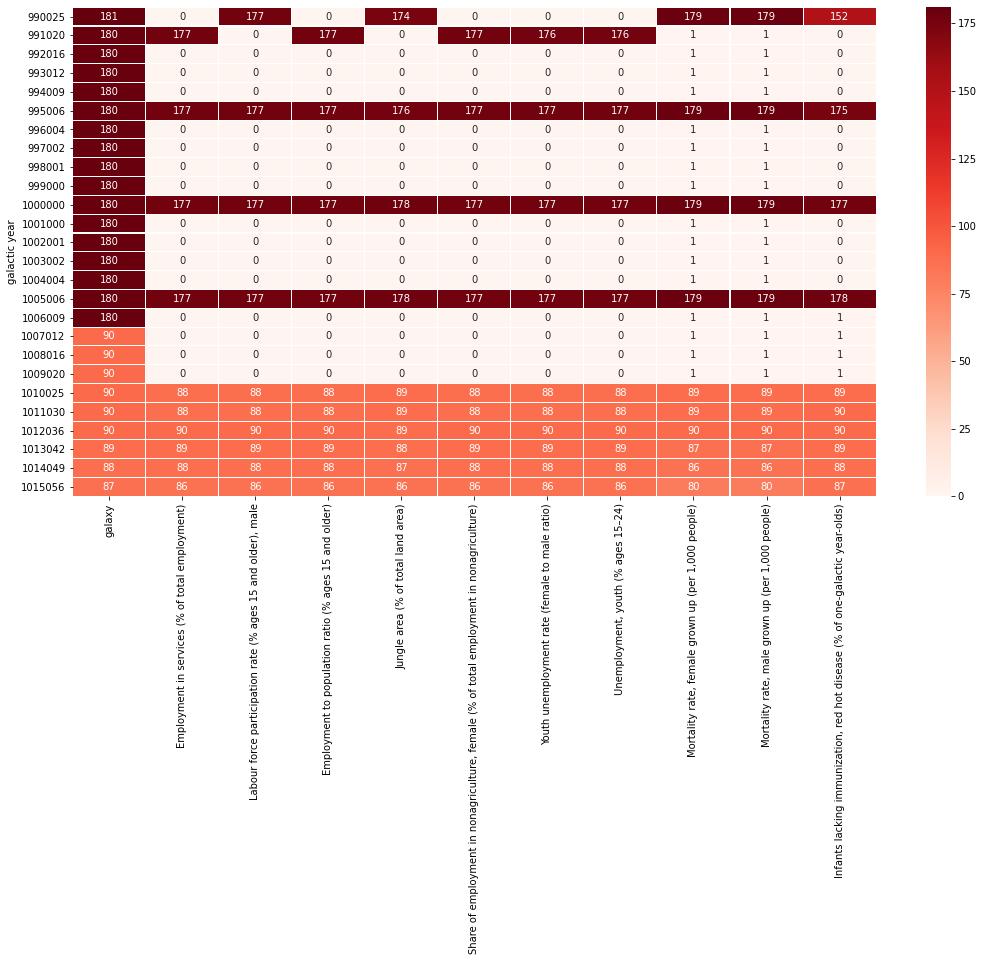

Data distribution: 



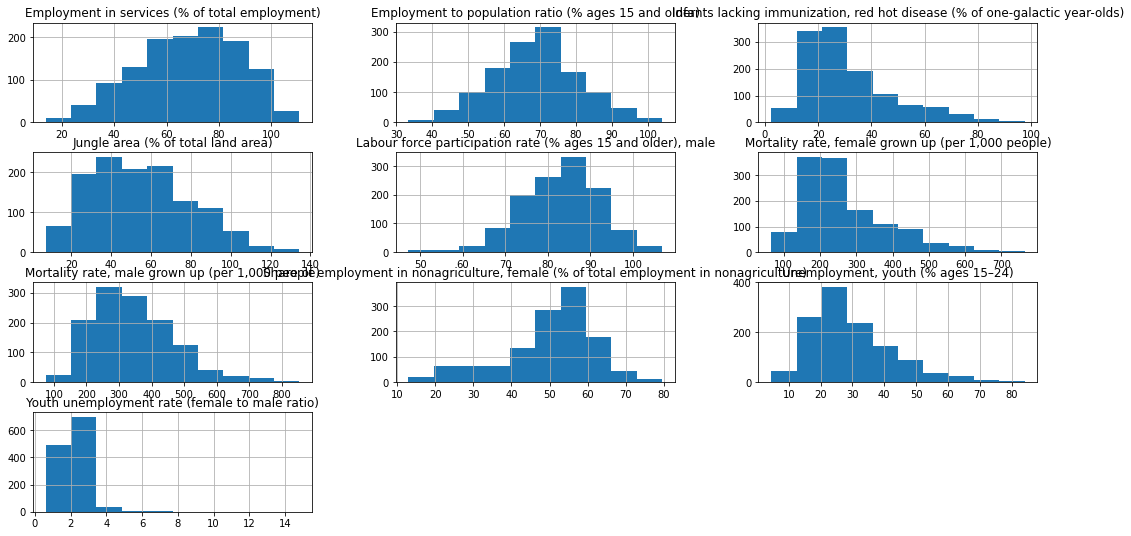

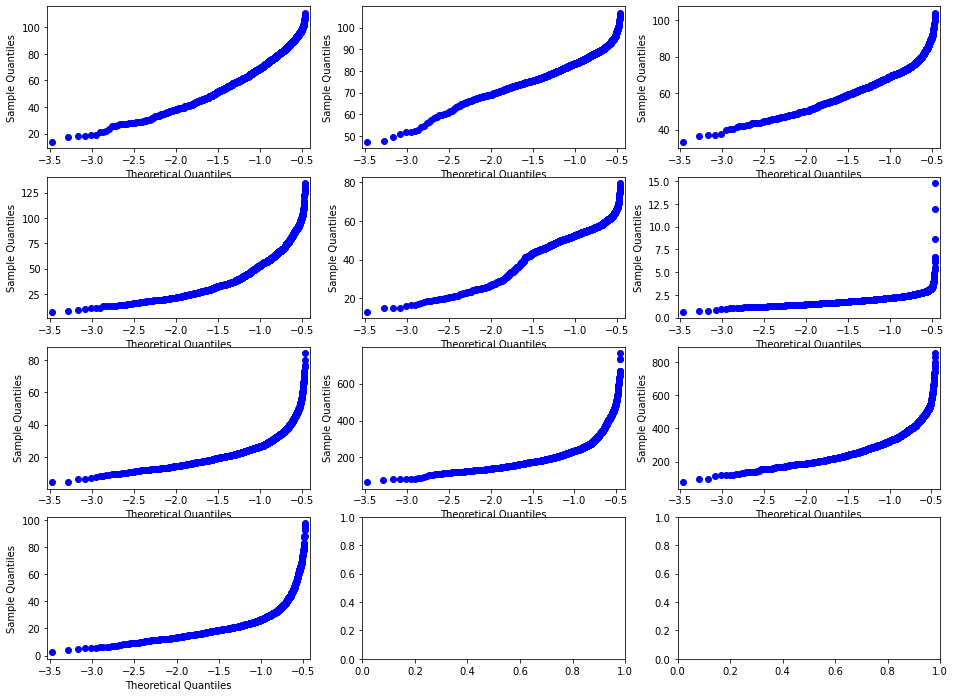

Data correlation: 



Employment in services (% of total employment)                                             0.49
Labour force participation rate (% ages 15 and older), male                               -0.21
Employment to population ratio (% ages 15 and older)                                      -0.04
Jungle area (% of total land area)                                                        -0.02
Share of employment in nonagriculture, female (% of total employment in nonagriculture)    0.21
Youth unemployment rate (female to male ratio)                                            -0.15
Unemployment, youth (% ages 15–24)                                                         0.00
Mortality rate, female grown up (per 1,000 people)                                        -0.44
Mortality rate, male grown up (per 1,000 people)                                          -0.45
Infants lacking immunization, red hot disease (% of one-galactic year-olds)               -0.24
dtype: float64



 -------------------------------------------------- 



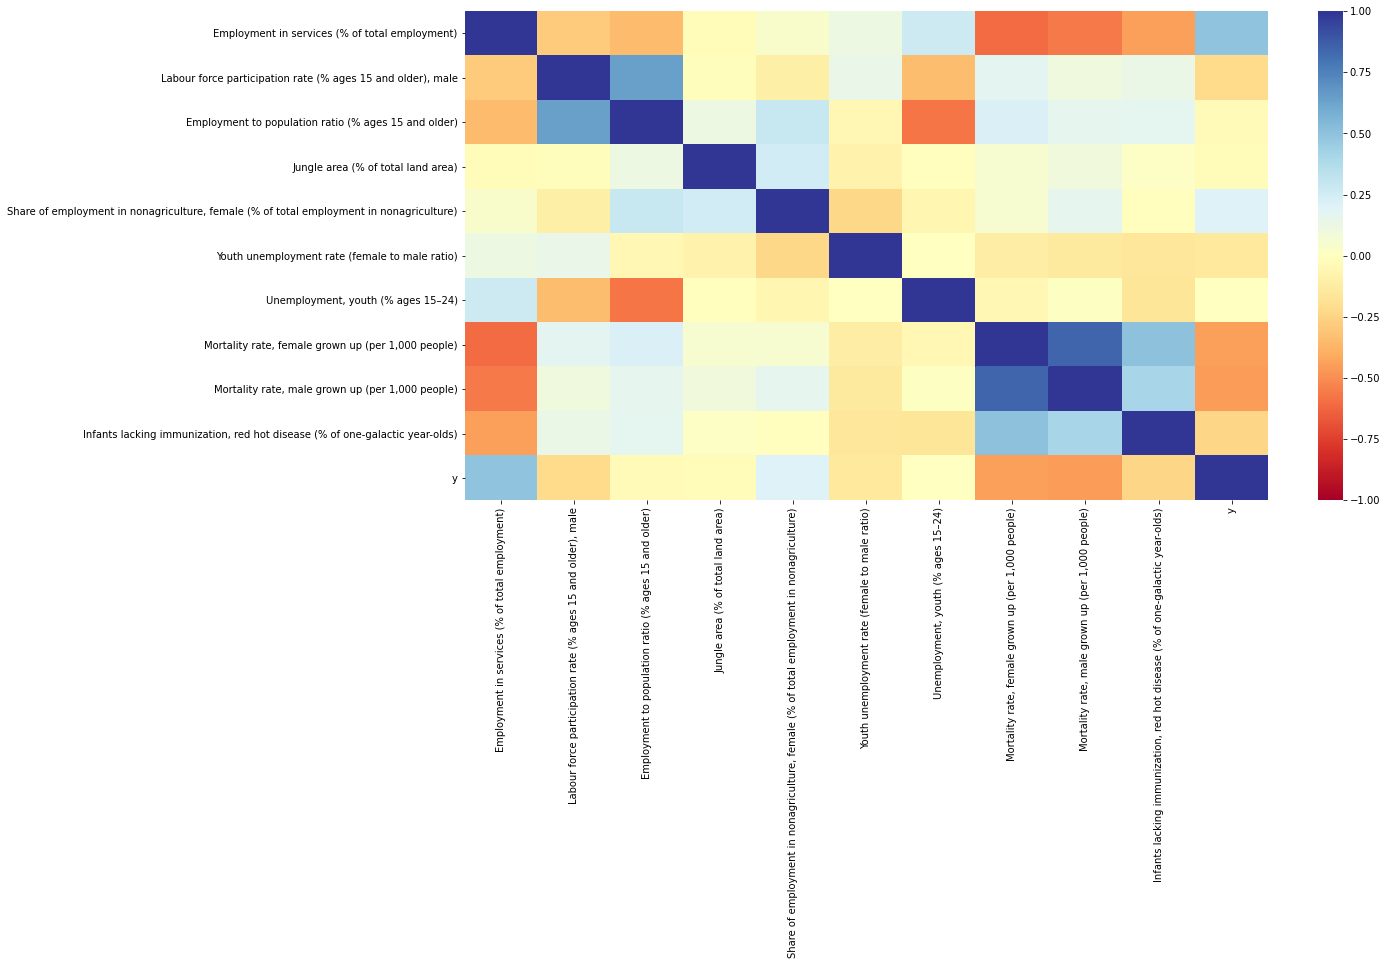

In [242]:
data_desc(data_train, start_col=30)

40-50:

Data head: 



Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)  \
0                                               8.22                                 
1                                              21.01                                 
2                                              18.95                                 
3                                                nan                                 
4                                              11.13                                 
5                                                nan                                 
6                                              44.47                                 
7                                               8.86                                 
8                                              23.52                                 
9                                              44.39                                 

   Gross galactic product (GGP) per capita  \
0                                21,158.32   
1                                24,984.04   
2                                19,860.12   
3                                      nan   
4                                75,156.05   
5                                22,301.08   
6                                19,047.28   
7                                29,232.82   
8                                23,416.98   
9                                34,280.14   

   Gross galactic product (GGP), total  \
0                             7,760.64   
1                             6,969.14   
2                             3,276.63   
3                                  nan   
4                             8,957.40   
5                             5,067.51   
6                             7,931.24   
7                             4,033.29   
8                             4,492.55   
9                             5,779.12   

   Outer Galaxies direct investment, net inflows (% of GGP)  \
0                                              13.62          
1                                              19.48          
2                                              13.36          
3                                                nan          
4                                                nan          
5                                              11.54          
6                                              10.05          
7                                              -5.27          
8                                              18.32          
9                                              16.29          

   Exports and imports (% of GGP)  \
0                           94.86   
1                           77.94   
2                           87.51   
3                             nan   
4                          241.90   
5                          132.41   
6                           86.68   
7                             nan   
8                          131.97   
9                           89.49   

   Share of seats in senate (% held by female)  Natural resource depletion  \
0                                          nan                        8.44   
1                                          nan                       12.55   
2                                          nan                       13.95   
3                                          nan                         nan   
4                                          nan                       15.09   
5                                          nan                        8.87   
6                                          nan                       12.46   
7                                          nan                       15.16   
8                                          nan                       40.90   
9                                          nan                       10.62   

   Mean years of education, female (galactic years)  \
0                                               nan   
1              

Data description: 



Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)  \
count                                           1,219.00                                 
mean                                               18.80                                 
std                                                11.51                                 
min                                                -1.32                                 
25%                                                11.91                                 
50%                                                15.34                                 
75%                                                21.36                                 
max                                                72.43                                 

       Gross galactic product (GGP) per capita  \
count                                 1,202.00   
mean                                 33,338.26   
std                                  18,946.70   
min                                   4,007.14   
25%                                  21,175.03   
50%                                  27,952.62   
75%                                  40,374.97   
max                                 134,636.65   

       Gross galactic product (GGP), total  \
count                             1,202.00   
mean                              7,749.98   
std                               7,167.78   
min                                -933.22   
25%                               5,479.46   
50%                               7,130.47   
75%                               8,786.80   
max                             112,391.32   

       Outer Galaxies direct investment, net inflows (% of GGP)  \
count                                           1,169.00          
mean                                               18.34          
std                                                15.38          
min                                                -5.27          
25%                                                13.02          
50%                                                16.75          
75%                                                20.93          
max                                               362.55          

       Exports and imports (% of GGP)  \
count                        1,144.00   
mean                           133.44   
std                             53.01   
min                             18.99   
25%                            101.38   
50%                            125.73   
75%                            154.89   
max                            477.06   

       Share of seats in senate (% held by female)  \
count                                     1,123.00   
mean                                         26.62   
std                                          11.08   
min                                           4.23   
25%                                          18.44   
50%                                          24.48   
75%                                          33.25   
max                                          69.85   

       Natural resource depletion  \
count                    1,132.00   
mean                        13.77   
std                          9.60   
min                         -0.37   
25%                          8.62   
50%                         11.28   
75%                         15.55   
max                        100.41   

       Mean years of education, female (galactic years)  \
count                                          1,140.00   
mean                                              10.59   
std                                                3.70   
min                                                1.32   
25%                                                7.49   
50%                                               10.59   
75%                                               13.57   
max                                               18.49   

   

Data fullness: 



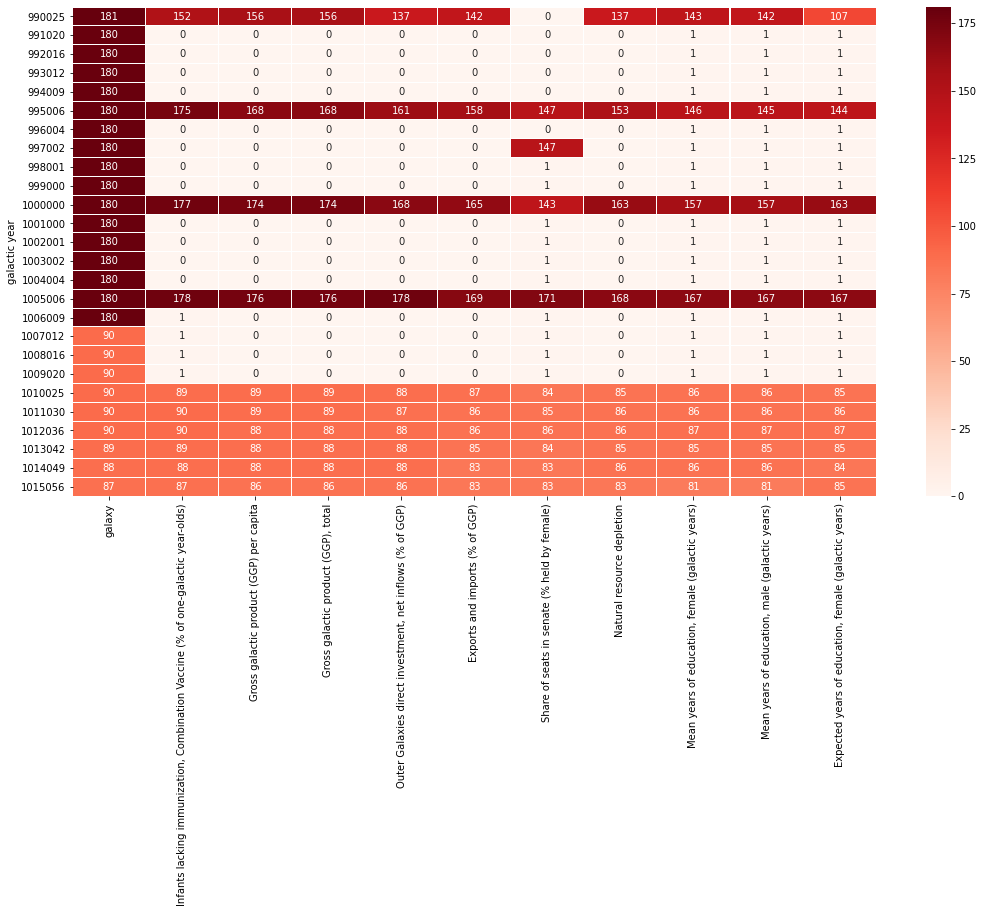

Data distribution: 



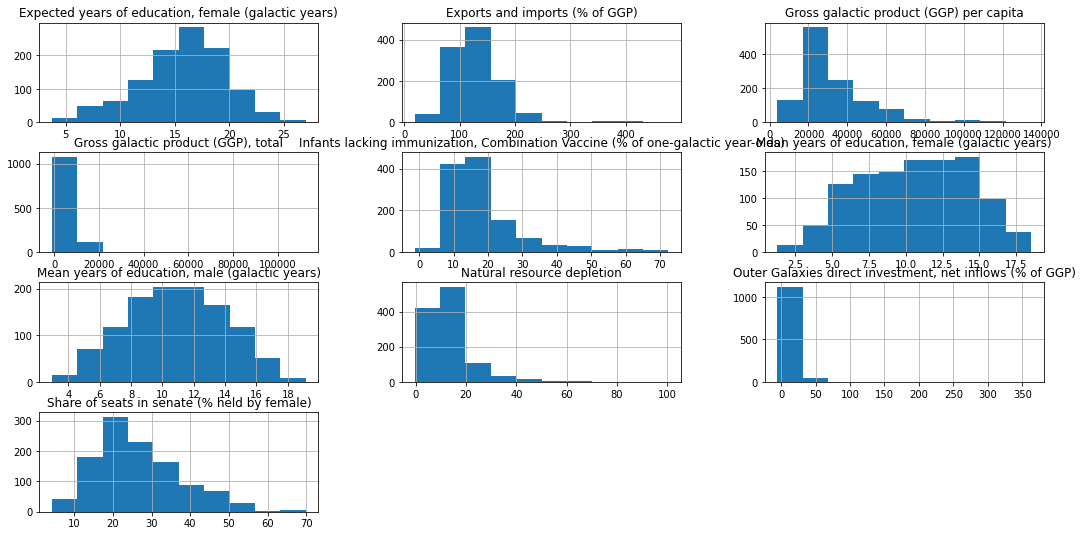

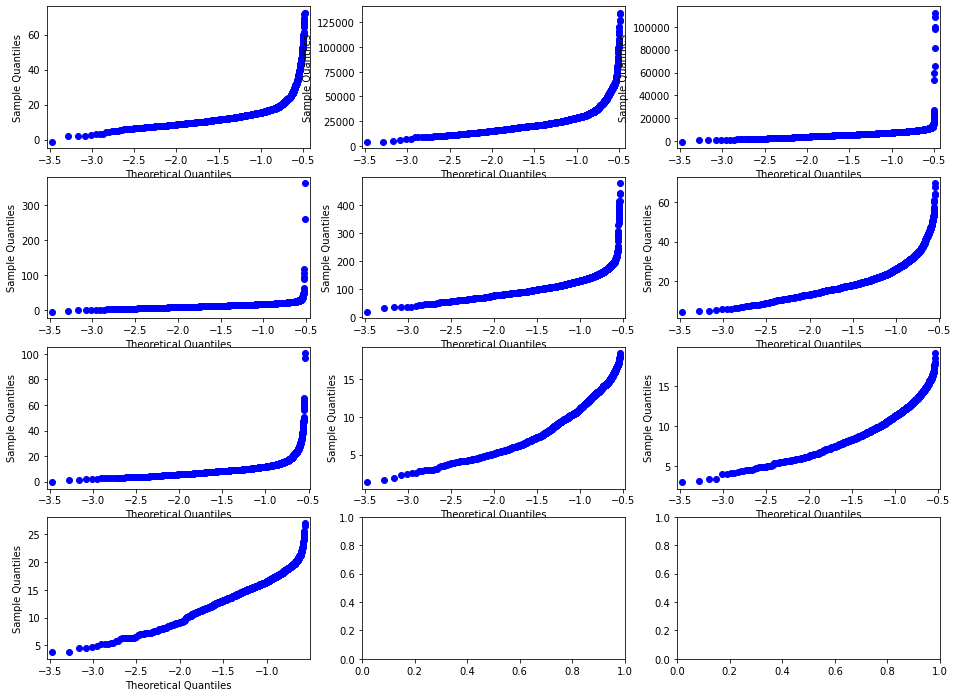

Data correlation: 



Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)   -0.25
Gross galactic product (GGP) per capita                                            0.58
Gross galactic product (GGP), total                                               -0.01
Outer Galaxies direct investment, net inflows (% of GGP)                           0.13
Exports and imports (% of GGP)                                                     0.26
Share of seats in senate (% held by female)                                        0.38
Natural resource depletion                                                        -0.22
Mean years of education, female (galactic years)                                   0.55
Mean years of education, male (galactic years)                                     0.57
Expected years of education, female (galactic years)                               0.56
dtype: float64



 -------------------------------------------------- 



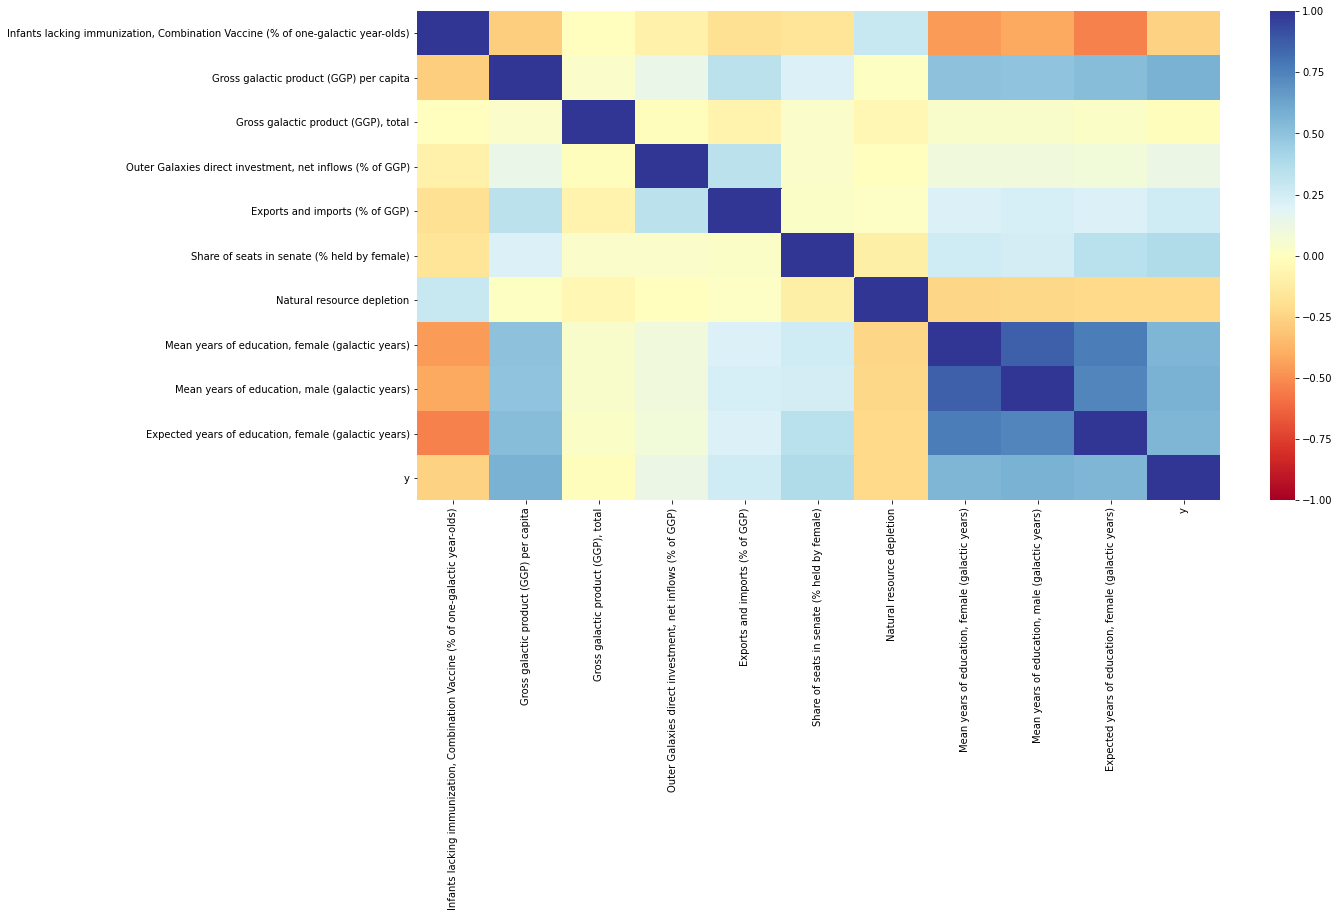

In [243]:
data_desc(data_train, start_col=40)

50-60:

Data head: 



Expected years of education, male (galactic years)  \
0                                                nan    
1                                              13.48    
2                                               6.81    
3                                                nan    
4                                                nan    
5                                              12.77    
6                                                nan    
7                                              14.17    
8                                              18.42    
9                                                nan    

   Maternal mortality ratio (deaths per 100,000 live births)  \
0                                           1,237.23           
1                                             544.46           
2                                           1,537.95           
3                                           2,016.66           
4                                             232.57           
5                                             779.74           
6                                             851.25           
7                                             298.89           
8                                             968.54           
9                                             929.08           

   Renewable energy consumption (% of total final energy consumption)  \
0                                             118.43                    
1                                              53.75                    
2                                             126.06                    
3                                                nan                    
4                                              39.19                    
5                                                nan                    
6                                              57.86                    
7                                                nan                    
8                                              92.11                    
9                                             109.24                    

   Estimated gross galactic income per capita, male  \
0                                               nan   
1                                               nan   
2                                               nan   
3                                               nan   
4                                               nan   
5                                               nan   
6                                               nan   
7                                               nan   
8                                               nan   
9                                               nan   

   Estimated gross galactic income per capita, female  \
0                                                nan    
1                                                nan    
2                                                nan    
3                                                nan    
4                                                nan    
5                                                nan    
6                                                nan    
7                                                nan    
8                                                nan    
9                                                nan    

   Rural population with access to electricity (%)  \
0                                              nan   
1                                              nan   
2                                              nan   
3                                              nan   
4                                           134.97   
5                                              nan   
6                                            44.18   
7                                              nan   
8                                              nan   
9                                              nan   

   Domestic credit provided by financ

Data description: 



Expected years of education, male (galactic years)  \
count                                           1,108.00    
mean                                               14.99    
std                                                 3.23    
min                                                 3.84    
25%                                                13.17    
50%                                                14.98    
75%                                                17.09    
max                                                29.05    

       Maternal mortality ratio (deaths per 100,000 live births)  \
count                                           1,252.00           
mean                                              554.34           
std                                               359.38           
min                                                39.18           
25%                                               322.72           
50%                                               441.95           
75%                                               680.90           
max                                             3,178.33           

       Renewable energy consumption (% of total final energy consumption)  \
count                                           1,235.00                    
mean                                               63.73                    
std                                                32.25                    
min                                                -1.05                    
25%                                                38.02                    
50%                                                55.31                    
75%                                                87.35                    
max                                               146.13                    

       Estimated gross galactic income per capita, male  \
count                                          1,055.00   
mean                                          42,115.32   
std                                           24,076.41   
min                                            4,247.34   
25%                                           26,665.47   
50%                                           35,510.06   
75%                                           50,069.35   
max                                          187,663.57   

       Estimated gross galactic income per capita, female  \
count                                           1,055.00    
mean                                           23,037.55    
std                                            13,075.77    
min                                              -947.54    
25%                                            14,589.01    
50%                                            19,431.72    
75%                                            27,312.73    
max                                            83,638.78    

       Rural population with access to electricity (%)  \
count                                         1,029.00   
mean                                            108.28   
std                                              39.65   
min                                               1.53   
25%                                              76.99   
50%                                             123.89   
75%                                             138.28   
max                                             174.91   

       Domestic credit provided by financial sector (% of GGP)  \
count                                           1,079.00         
mean                                              118.69         
std                                                61.43         
min                                               -38.30         
25%                                                78.54         
50%                                               104.42         
75%                                               145.76         
max              

Data fullness: 



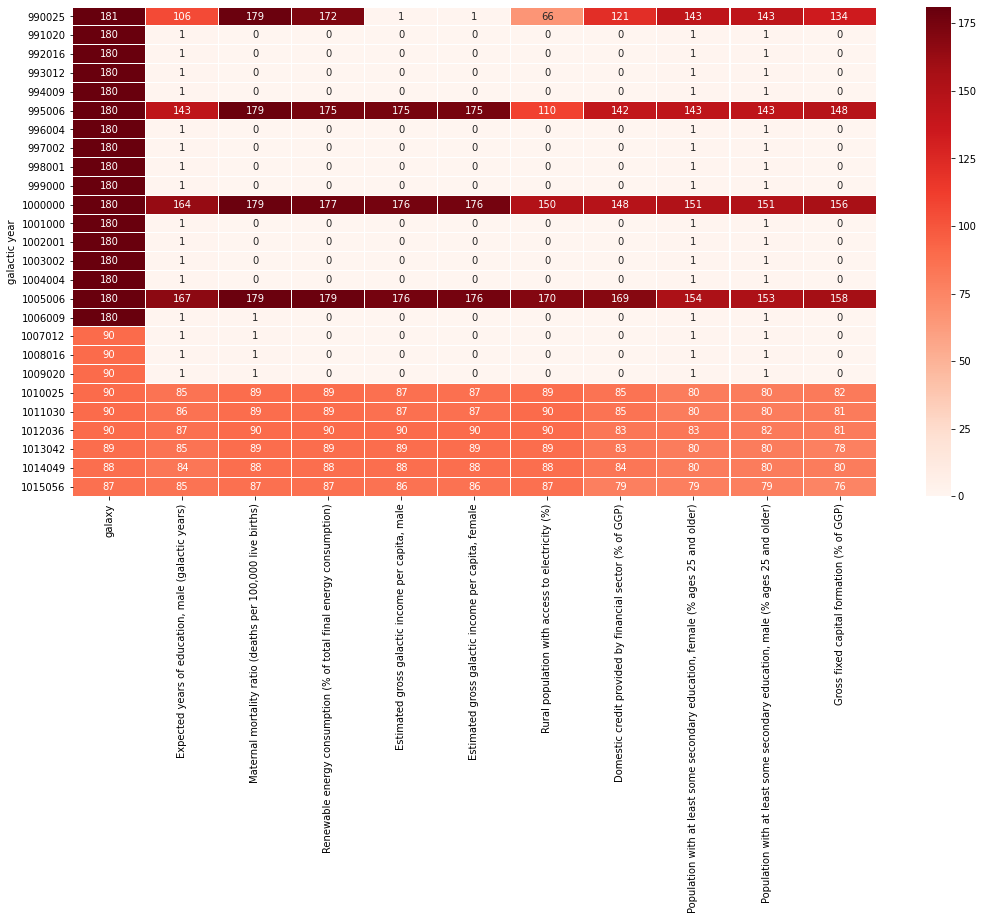

Data distribution: 



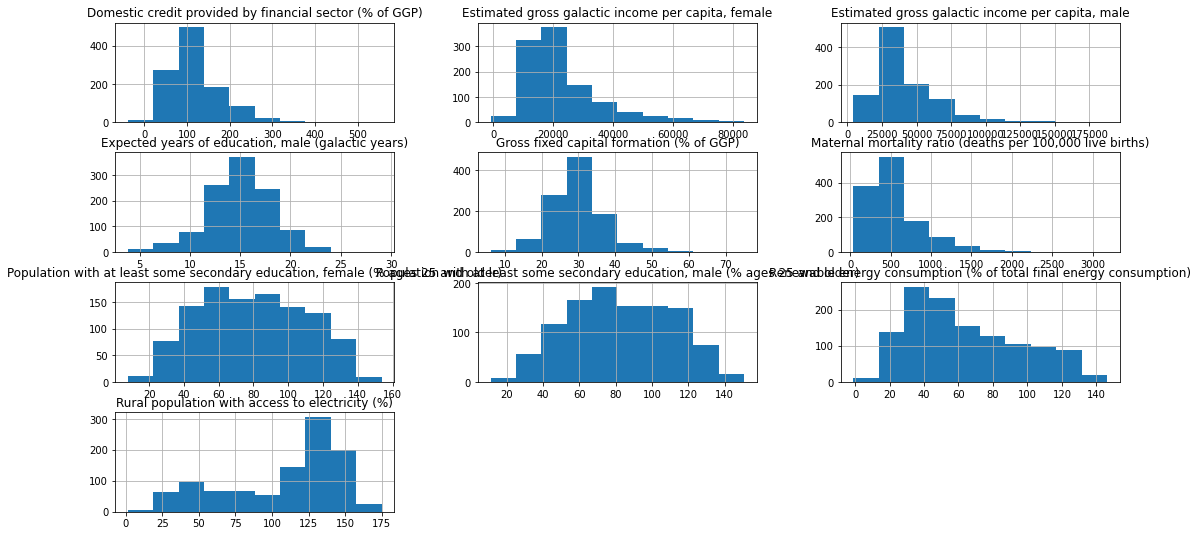

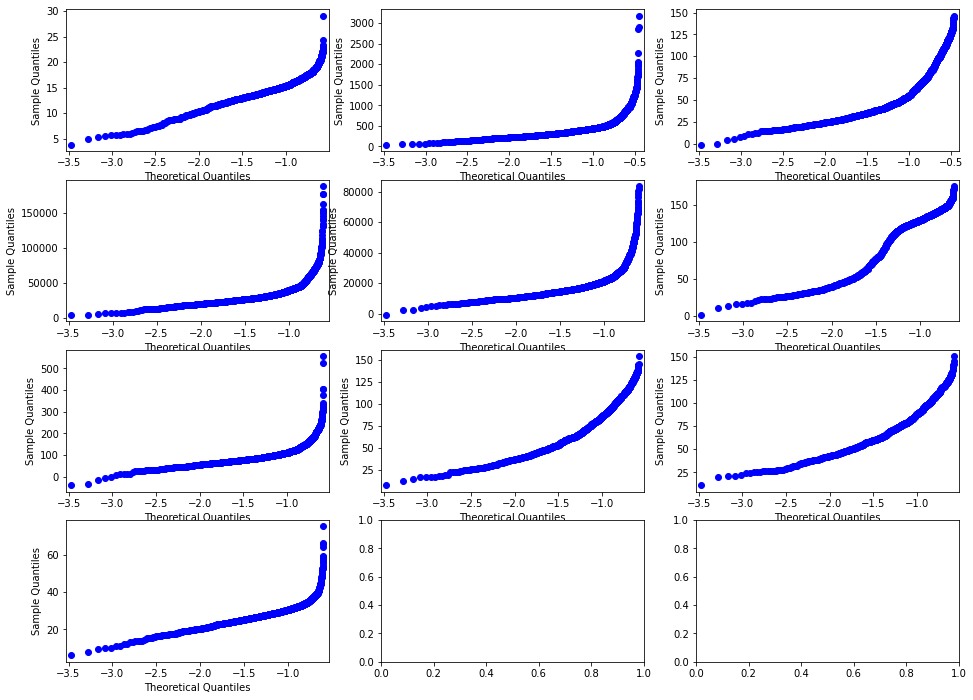

Data correlation: 



Expected years of education, male (galactic years)                                 0.57
Maternal mortality ratio (deaths per 100,000 live births)                         -0.35
Renewable energy consumption (% of total final energy consumption)                -0.23
Estimated gross galactic income per capita, male                                   0.52
Estimated gross galactic income per capita, female                                 0.67
Rural population with access to electricity (%)                                    0.44
Domestic credit provided by financial sector (% of GGP)                            0.53
Population with at least some secondary education, female (% ages 25 and older)    0.53
Population with at least some secondary education, male (% ages 25 and older)      0.53
Gross fixed capital formation (% of GGP)                                          -0.02
dtype: float64



 -------------------------------------------------- 



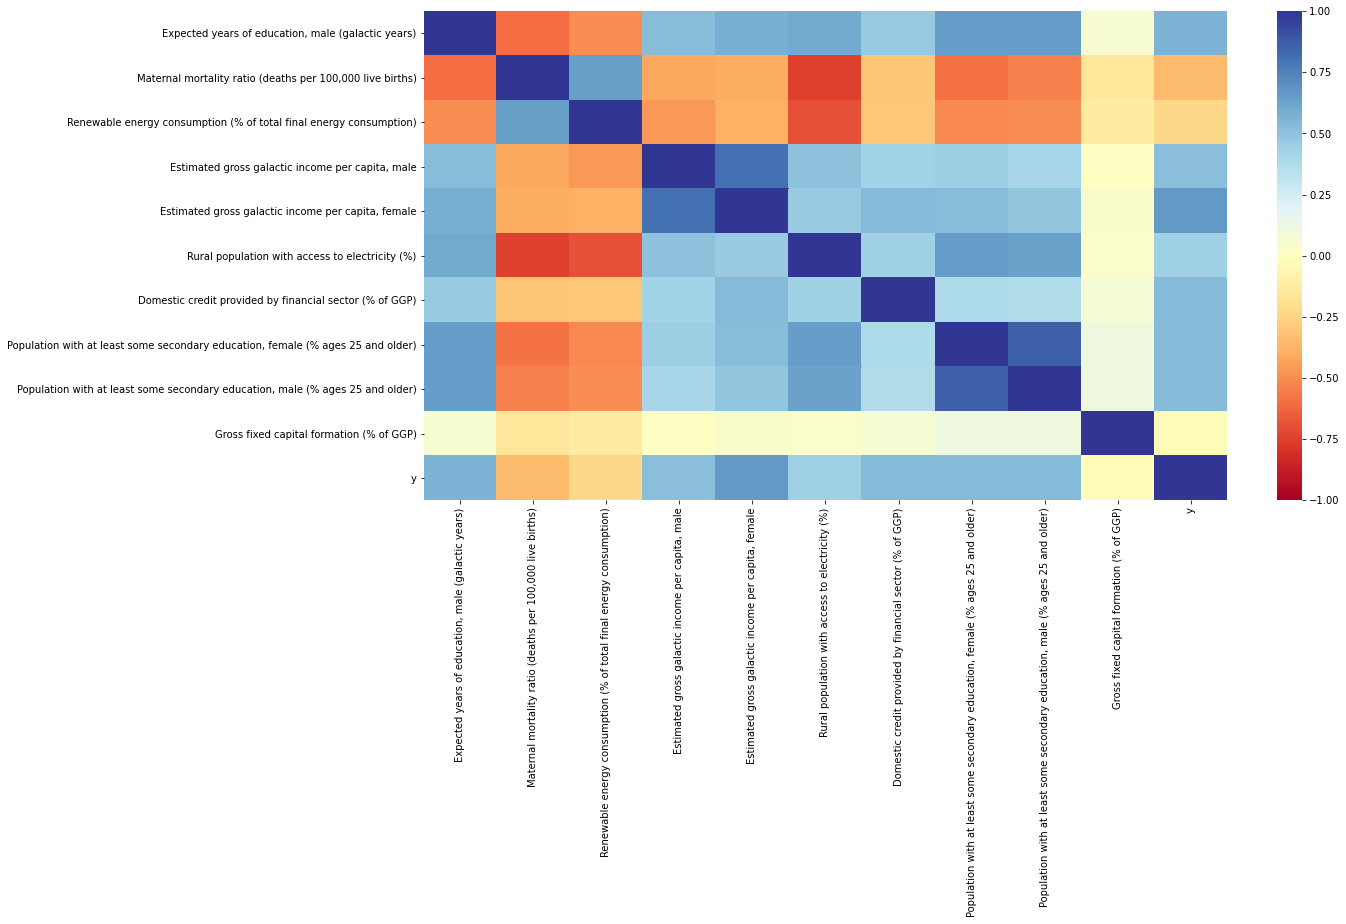

In [244]:
data_desc(data_train, start_col=50)

60-70:

Data head: 



Remittances, inflows (% of GGP)  \
0                              nan   
1                             6.23   
2                             4.14   
3                              nan   
4                              nan   
5                             8.38   
6                             5.99   
7                             5.36   
8                             8.77   
9                              nan   

   Population with at least some secondary education (% ages 25 and older)  \
0                                                nan                         
1                                              44.78                         
2                                              24.03                         
3                                                nan                         
4                                              66.67                         
5                                              64.72                         
6                                              92.42                         
7                                                nan                         
8                                              60.21                         
9                                              36.42                         

   Intergalactic inbound tourists (thousands)  \
0                                         nan   
1                                         nan   
2                                         nan   
3                                         nan   
4                                         nan   
5                                         nan   
6                                         nan   
7                                         nan   
8                                         nan   
9                                         nan   

   Gross enrolment ratio, primary (% of primary under-age population)  \
0                                                nan                    
1                                             120.89                    
2                                              96.63                    
3                                                nan                    
4                                                nan                    
5                                             133.54                    
6                                             112.32                    
7                                             134.28                    
8                                             139.02                    
9                                                nan                    

   Respiratory disease incidence (per 100,000 people)  \
0                                                nan    
1                                                nan    
2                                                nan    
3                                                nan    
4                                                nan    
5                                                nan    
6                                                nan    
7                                                nan    
8                                                nan    
9                                                nan    

   Interstellar phone subscriptions (per 100 people)  \
0                                                nan   
1                                                nan   
2                                                nan   
3                                                nan   
4                                                nan   
5                                                nan   
6                                                nan   
7                                                nan   
8                                                nan   
9                                                nan   

   Interstellar Data Net users, total (% of population)  \
0                                                nan      
1                 

Data description: 



Remittances, inflows (% of GGP)  \
count                         1,028.00   
mean                             11.93   
std                               9.02   
min                              -0.08   
25%                               7.42   
50%                              10.04   
75%                              13.23   
max                             172.73   

       Population with at least some secondary education (% ages 25 and older)  \
count                                           1,051.00                         
mean                                               81.10                         
std                                                29.88                         
min                                                 9.87                         
25%                                                56.91                         
50%                                                80.39                         
75%                                               103.96                         
max                                               149.49                         

       Intergalactic inbound tourists (thousands)  \
count                                      995.00   
mean                                   115,534.30   
std                                    113,381.55   
min                                     -9,669.28   
25%                                     78,249.62   
50%                                    101,776.45   
75%                                    124,652.54   
max                                  1,228,843.07   

       Gross enrolment ratio, primary (% of primary under-age population)  \
count                                           1,038.00                    
mean                                              115.66                    
std                                                17.31                    
min                                                35.86                    
25%                                               109.73                    
50%                                               117.51                    
75%                                               124.39                    
max                                               178.40                    

       Respiratory disease incidence (per 100,000 people)  \
count                                             896.00    
mean                                              313.41    
std                                               195.34    
min                                                31.69    
25%                                               193.63    
50%                                               256.15    
75%                                               361.77    
max                                             1,380.91    

       Interstellar phone subscriptions (per 100 people)  \
count                                             891.00   
mean                                              116.62   
std                                                50.07   
min                                                18.09   
25%                                                72.95   
50%                                               121.21   
75%                                               156.30   
max                                               271.31   

       Interstellar Data Net users, total (% of population)  \
count                                             872.00      
mean                                               57.89      
std                                                29.80      
min                                                 0.51      
25%                                                34.15      
50%                                                49.28      
75%                                                77.88      
max                                               141.38      

       Current health expenditure (% of GGP)  \
count     

Data fullness: 



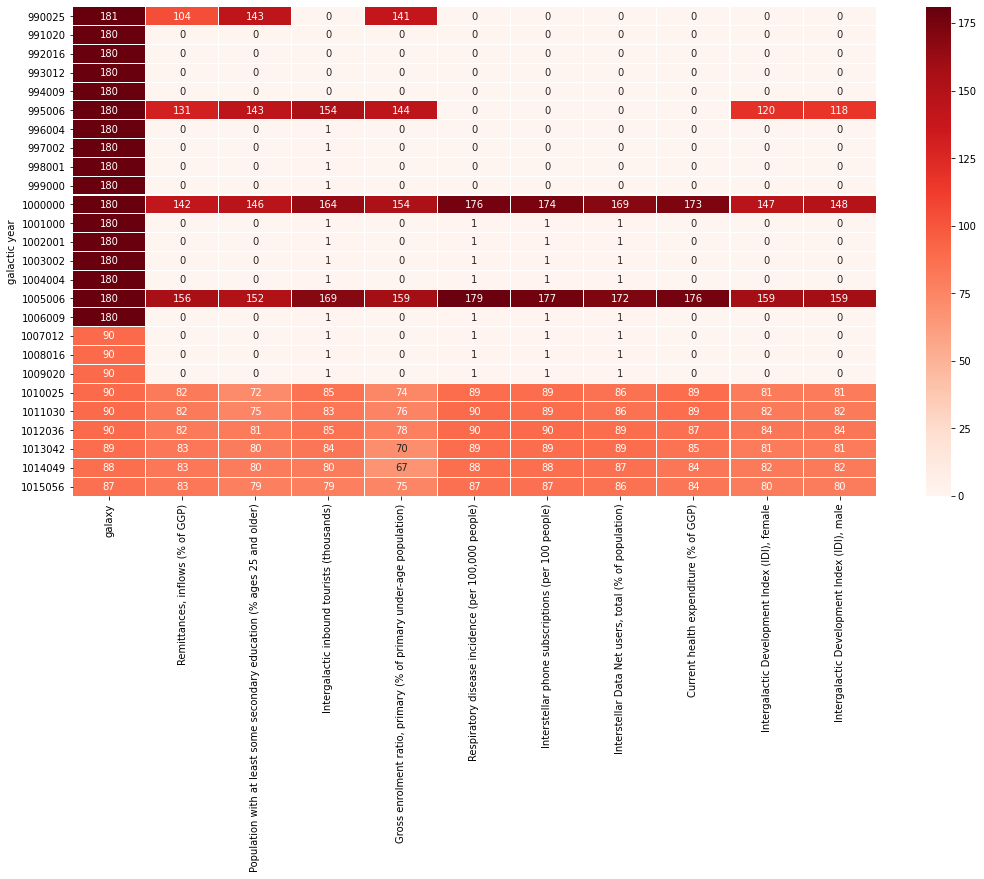

Data distribution: 



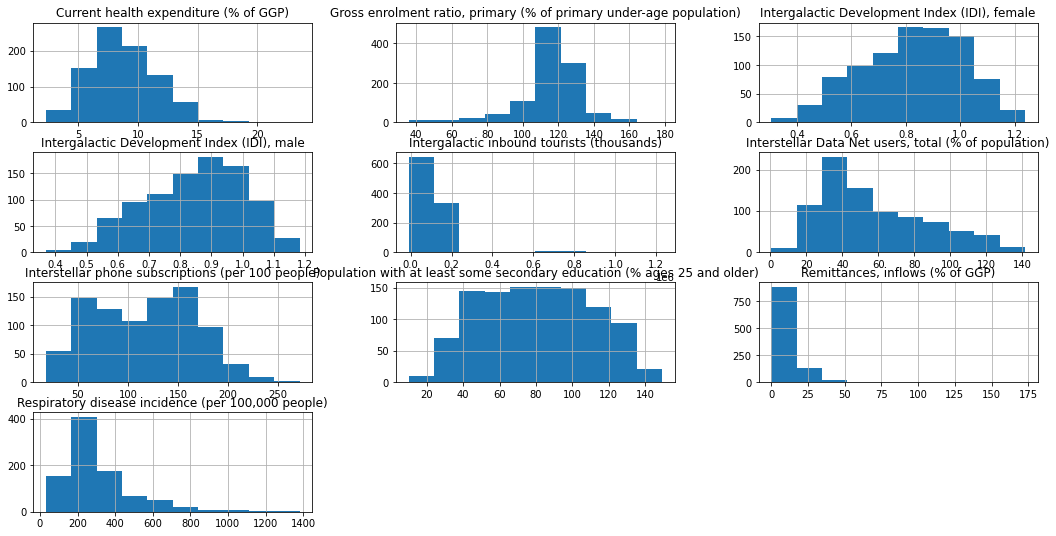

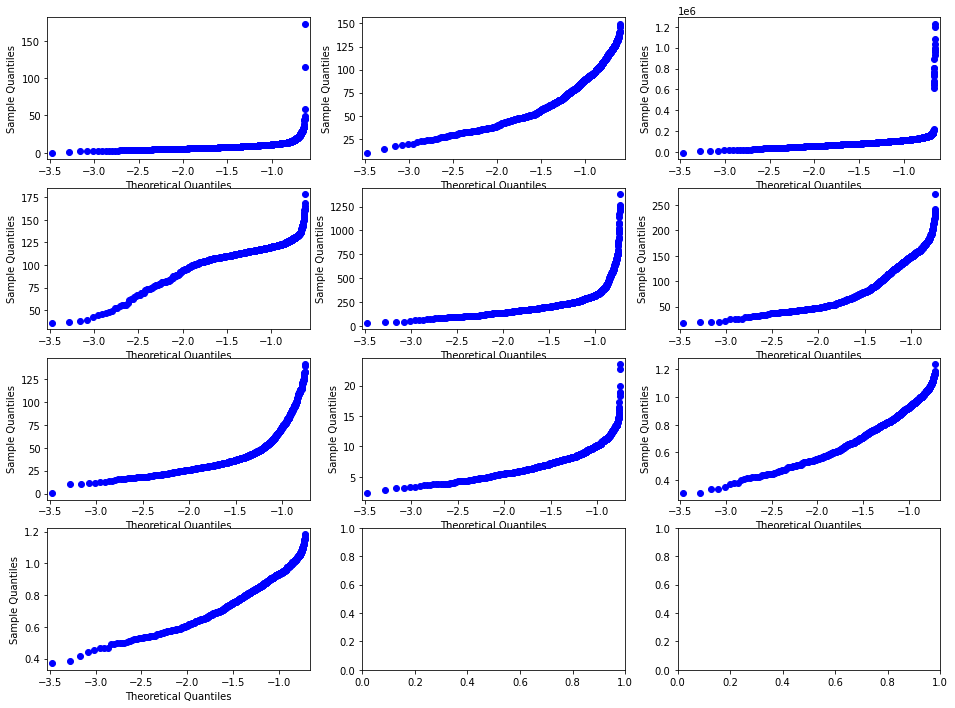

Data correlation: 



Remittances, inflows (% of GGP)                                           -0.18
Population with at least some secondary education (% ages 25 and older)    0.52
Intergalactic inbound tourists (thousands)                                -0.03
Gross enrolment ratio, primary (% of primary under-age population)         0.03
Respiratory disease incidence (per 100,000 people)                        -0.33
Interstellar phone subscriptions (per 100 people)                          0.31
Interstellar Data Net users, total (% of population)                       0.65
Current health expenditure (% of GGP)                                      0.37
Intergalactic Development Index (IDI), female                              0.61
Intergalactic Development Index (IDI), male                                0.62
dtype: float64



 -------------------------------------------------- 



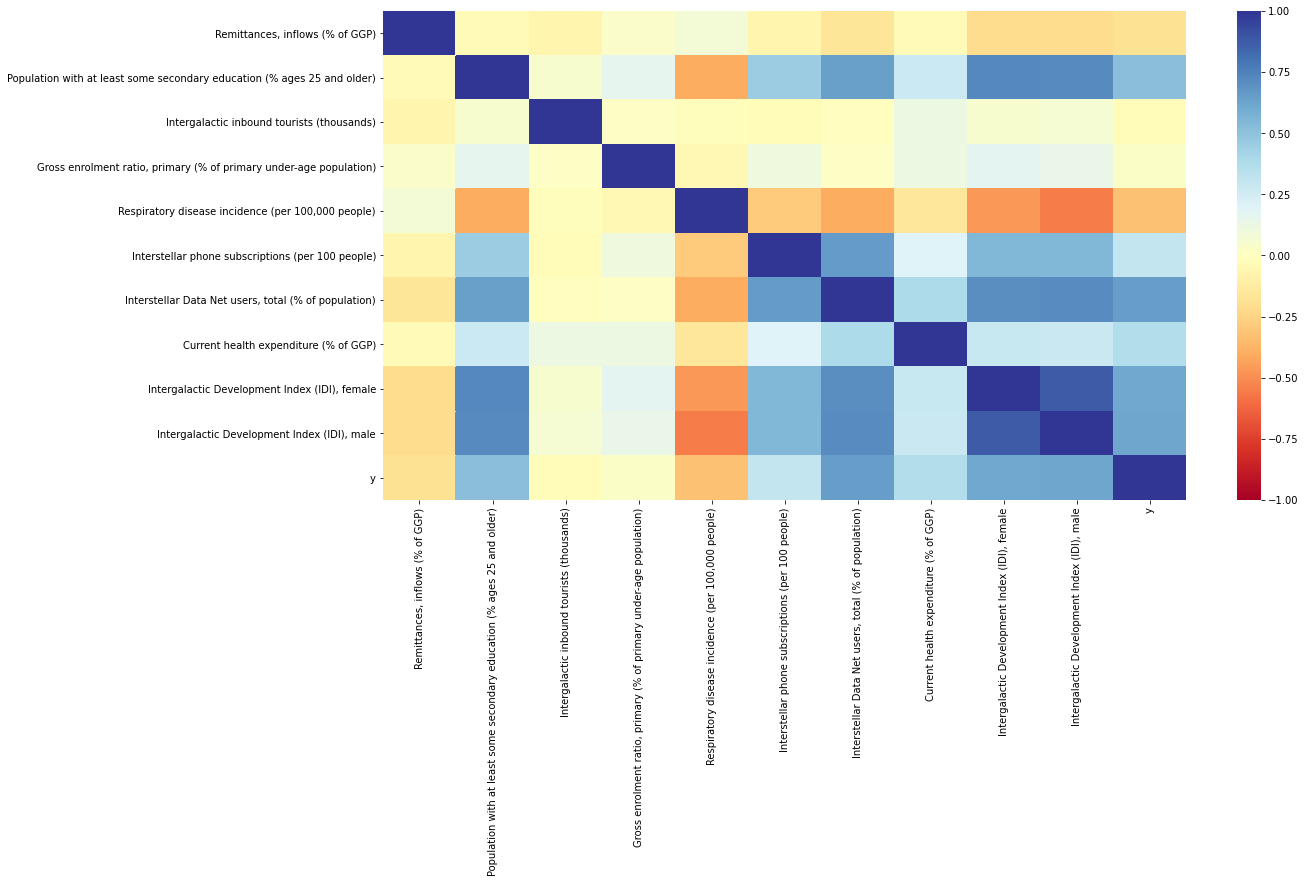

In [245]:
data_desc(data_train, start_col=60)

70-80:

Data head: 



Gender Development Index (GDI)  \
0                             nan   
1                             nan   
2                             nan   
3                             nan   
4                             nan   
5                             nan   
6                             nan   
7                             nan   
8                             nan   
9                             nan   

   Intergalactic Development Index (IDI), female, Rank  \
0                                                nan     
1                                                nan     
2                                                nan     
3                                                nan     
4                                                nan     
5                                                nan     
6                                                nan     
7                                                nan     
8                                                nan     
9                                                nan     

   Intergalactic Development Index (IDI), male, Rank  Adjusted net savings   \
0                                                nan                    nan   
1                                                nan                  19.18   
2                                                nan                  21.15   
3                                                nan                    nan   
4                                                nan                    nan   
5                                                nan                  40.12   
6                                                nan                  12.98   
7                                                nan                    nan   
8                                                nan                  -4.71   
9                                                nan                   8.73   

   Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total  \
0                                                nan                           
1                                                nan                           
2                                               6.53                           
3                                               5.91                           
4                                               5.61                           
5                                               3.98                           
6                                               4.32                           
7                                               4.19                           
8                                               6.15                           
9                                               6.68                           

   Private galaxy capital flows (% of GGP)  Gender Inequality Index (GII)    y  
0                                      nan                            nan 0.05  
1                                    22.79                            nan 0.06  
2                                      nan                            nan 0.05  
3                                      nan                            nan 0.05  
4                                      nan                            nan 0.15  
5                                    21.01                            nan 0.05  
6                                      nan                            nan 0.05  
7                                      nan                            nan 0.06  
8                                      nan                            nan 0.05  
9                                      nan                            nan 0.05

Data description: 



Gender Development Index (GDI)  \
count                          914.00   
mean                             1.01   
std                              0.09   
min                              0.47   
25%                              0.97   
50%                              1.03   
75%                              1.07   
max                              1.18   

       Intergalactic Development Index (IDI), female, Rank  \
count                                             893.00     
mean                                              121.75     
std                                                46.27     
min                                                23.22     
25%                                                84.09     
50%                                               120.07     
75%                                               158.58     
max                                               232.72     

       Intergalactic Development Index (IDI), male, Rank  \
count                                             892.00   
mean                                              120.87   
std                                                46.80   
min                                                16.22   
25%                                                82.23   
50%                                               121.06   
75%                                               157.82   
max                                               233.92   

       Adjusted net savings   \
count                 912.00   
mean                   21.25   
std                    14.26   
min                   -76.74   
25%                    15.00   
50%                    22.18   
75%                    29.13   
max                    61.90   

       Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total  \
count                                             941.00                           
mean                                                6.44                           
std                                                 4.80                           
min                                                -1.19                           
25%                                                 4.11                           
50%                                                 5.31                           
75%                                                 6.81                           
max                                                36.54                           

       Private galaxy capital flows (% of GGP)  Gender Inequality Index (GII)  \
count                                   874.00                         844.00   
mean                                     22.26                           0.60   
std                                      34.34                           0.21   
min                                    -735.19                           0.09   
25%                                      17.23                           0.43   
50%                                      24.47                           0.62   
75%                                      31.75                           0.77   
max                                      95.94                           1.10   

             y  
count 3,865.00  
mean      0.08  
std       0.06  
min       0.01  
25%       0.05  
50%       0.06  
75%       0.09  
max       0.68

Data fullness: 



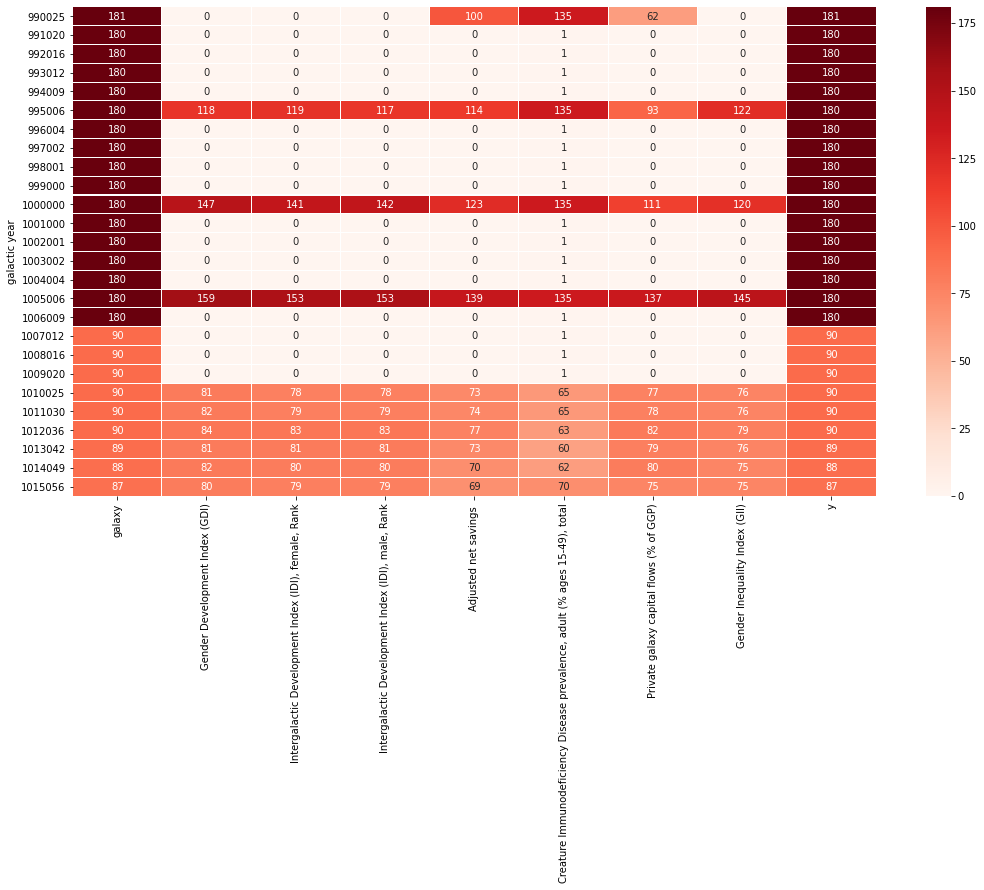

Data distribution: 



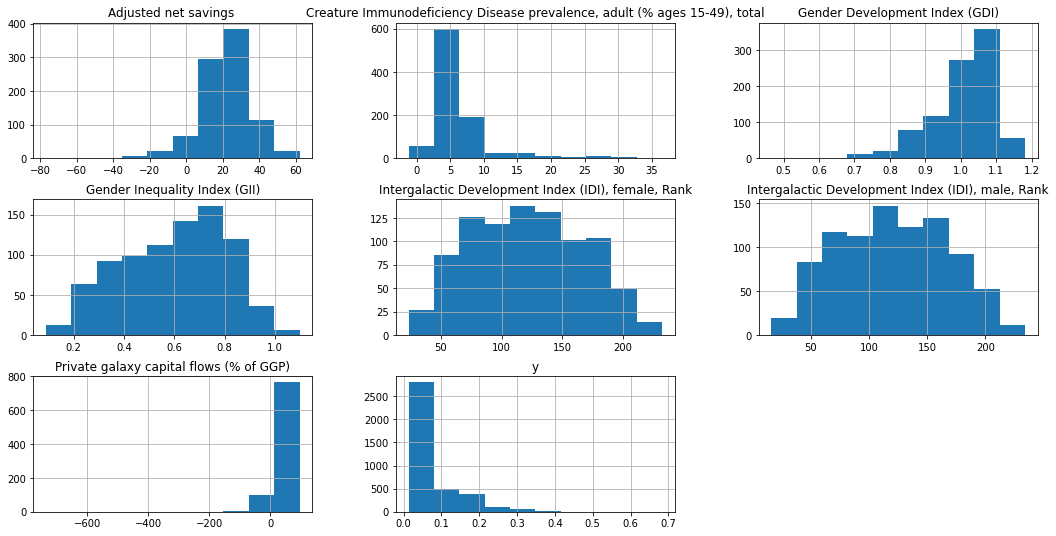

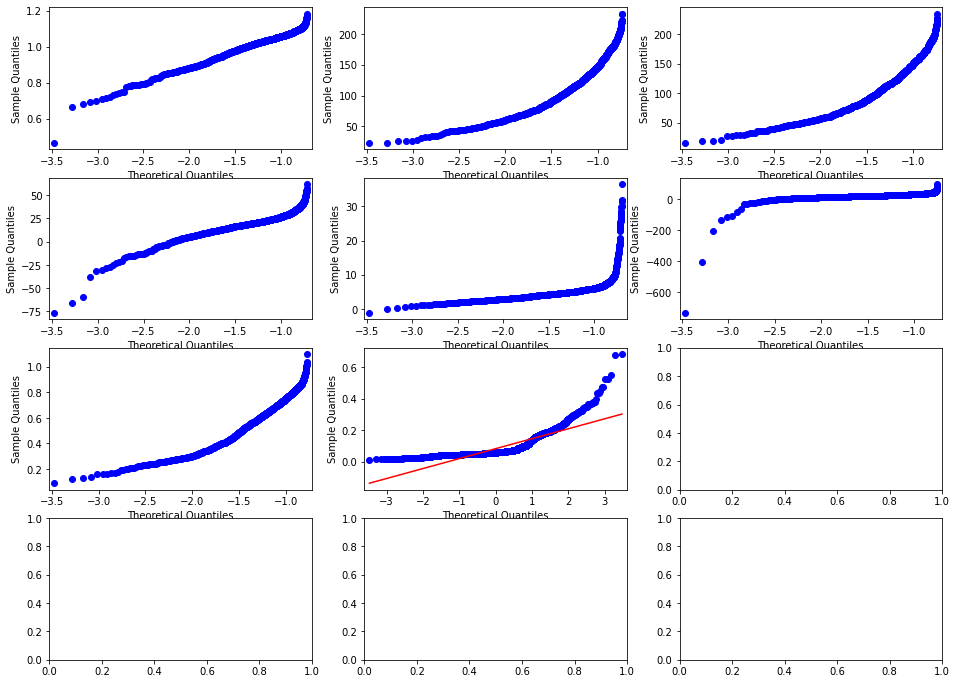

Data correlation: 



Gender Development Index (GDI)                                               0.34
Intergalactic Development Index (IDI), female, Rank                         -0.66
Intergalactic Development Index (IDI), male, Rank                           -0.68
Adjusted net savings                                                         0.16
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total   -0.23
Private galaxy capital flows (% of GGP)                                     -0.13
Gender Inequality Index (GII)                                               -0.72
y                                                                            1.00
dtype: float64



 -------------------------------------------------- 



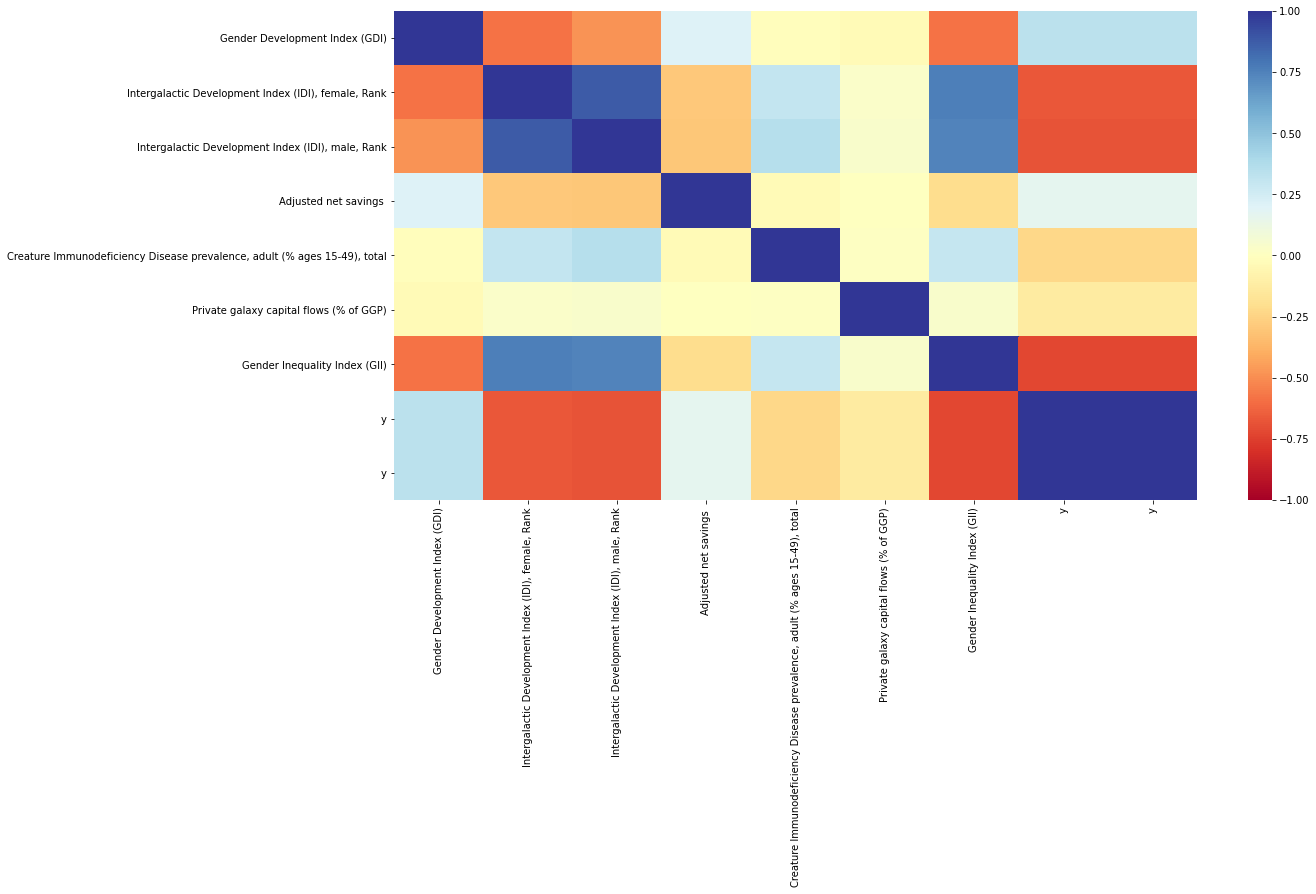

In [246]:
data_desc(data_train, start_col=70)

### check disribution (not done)

### percent cols (not done)

cols_percent = [x for x in data_train.columns if ('%' in x)]
cols_percent = [x for x in cols_percent if (any(data_train[x] > 100))]
(data_train[cols_percent] > 100).sum()

Будем считать, что у инопланетян другие проценты с максимумом > 100%

## Model

### train_df, test_df

In [193]:
train_df, test_df = train_test_split(data_train[data_train['galactic year'] >= 1010025], test_size=0.2, random_state=163)
print(train_df.shape, test_df.shape);
train_df.drop(['galaxy'], axis=1, inplace=True)
test_df.drop(['galaxy'], axis=1, inplace=True)
test_df = test_df.where(test_df > 0, np.abs)
train_df = train_df.where(train_df > 0, np.abs)
train_df.fillna(train_df.mean(), inplace=True);
test_df.fillna(test_df.mean(), inplace=True);

train_df_min = train_df.iloc[:,:-1].min()
train_df_max = train_df.iloc[:,:-1].max()
train_df.iloc[:,:-1] = (train_df.iloc[:,:-1] - train_df_min)/train_df_max

test_df_mean = test_df.iloc[:,:-1].min()
test_df_std = test_df.iloc[:,:-1].max()
test_df.iloc[:,:-1] = (test_df.iloc[:,:-1] - train_df_min)/train_df_max


rename_cols = dict()
for i, cn in enumerate(data_train.columns):
    if cn not in ['galaxy', 'galactic year', 'y']:
        rename_cols[cn] = 'col_' + str(i)

train_df.rename(columns=rename_cols, inplace=True)
test_df.rename(columns=rename_cols, inplace=True)

from sklearn.utils import shuffle
train_df = shuffle(train_df, random_state=42)

print(train_df.shape, test_df.shape);

(427, 80) (107, 80)
(427, 79) (107, 79)


### feature layer

In [194]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

for x in train_df.columns:
    if x not in ['galaxy', 'galactic year', 'y']:        
        feature_columns.append(tf.feature_column.numeric_column(x))
fp_feature_layer = layers.DenseFeatures(feature_columns)

### functions for model create, train, plot

In [267]:
#@title Define functions to create and train a model, and a plotting function
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
    #model.add(tf.keras.layers.Multiply()([model[-1], model[-1]]))
    model.add(tf.keras.layers.Dense(units=1, input_shape=(80,), 
                                    kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-6),
                                    bias_regularizer=regularizers.l2(1e-8),
                                    activity_regularizer=regularizers.l2(1e-8)
                                   ))
    #model.add(tf.keras.layers.Multiply())
    #model.add(tf.keras.layers.Dense(units=1, input_shape=(10,)))
    model.add(tf.keras.layers.Dense(units=1, input_shape=(40,)))
    model.add(tf.keras.layers.Dense(units=1, input_shape=(15,)))
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation='softplus'))

  # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer='adam',#tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=0.2)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist[["root_mean_squared_error", "val_root_mean_squared_error"]]

    return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label=list(rmse.columns))
    plt.legend(list(rmse.columns))
    plt.ylim([min(rmse.min())*0.94, max(rmse.max())* 1.05])
    plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


### training model

Epoch 1/300
341/341 [==============================] - 3s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2954 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1242
Epoch 2/300
341/341 [==============================] - 2s 4ms/step - loss: 0.0141 - root_mean_squared_error: 0.1127 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1190
Epoch 3/300
341/341 [==============================] - 2s 4ms/step - loss: 0.0131 - root_mean_squared_error: 0.1080 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1147
Epoch 4/300
341/341 [==============================] - 2s 5ms/step - loss: 0.0121 - root_mean_squared_error: 0.1033 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1087
Epoch 5/300
341/341 [==============================] - 2s 5ms/step - loss: 0.0106 - root_mean_squared_error: 0.0963 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1003
Epoch 6/300
341/341 [==============================] - 2s 5ms/step - loss: 0.0091 - root_mean_squared_error: 0.0880 - val_loss: 0.0096 

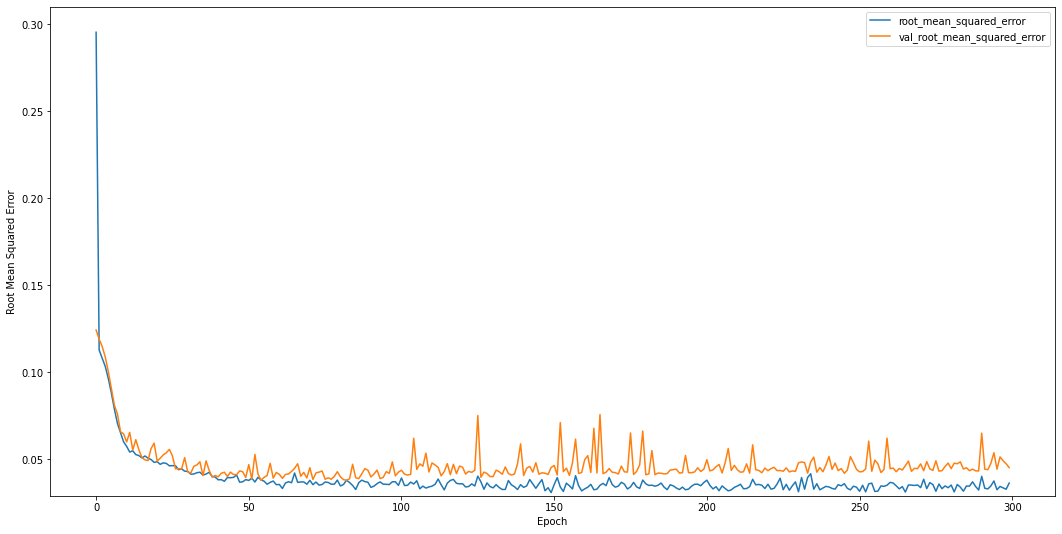


: Evaluate the new model against the test set:
107/107 [==============================] - 1s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0260


[0.0013008152600377798, 0.025980403646826744]

In [268]:
# The following variables are the hyperparameters.
learning_rate = 0.000003
epochs = 300
batch_size = 1
label_name = 'y'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

### predict values

In [259]:
data_test = pd.read_csv('test.csv')

data_test.drop('galaxy', axis=1, inplace=True)
data_test = data_test.where(data_test > 0, np.abs)
data_test.fillna(data_test.mean(), inplace=True);

data_test_min = data_test.min()
data_test_max = data_test.max()
data_test = (data_test - data_test_min)/data_test_max

data_test.rename(columns=rename_cols, inplace=True)

data_test_features = {name:np.array(value) for name, value in data_test.items()}

## Energy split

In [266]:
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
import numpy as np
import pandas as pd

pred = pd.read_csv('submit.csv')['pred']
data_test = pd.read_csv('test.csv')
sz = len(pred)

def func_en(En):
    print(-sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000)))
    return -sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000))

bounds = Bounds(0, 1)
linear_constraint = LinearConstraint([np.array(data_test['existence expectancy index'] < 0.7).astype('float'),
                                      np.ones(sz)], [50, 0], [np.inf, 500])

En0 = np.random.random(sz)
res = minimize(func_en, En0, method='trust-constr', jac='2-point', \
                   constraints=[linear_constraint], \
                   options={'verbose': 1}, bounds=bounds)

-15.368683965039237
-15.368683965574917
-15.368683965574917
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965751156
-15.368683965751156
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965542834
-15.368683965751156
-15.368683965542834
-15.368683965574917
-15.368683965751156
-15.368683965670082
-15.368683965751156
-15.368683965670082
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965751156
-15.368683965574917
-15.368683965751156
-15.368683965574917
-15.368683965670083
-15.368683965751156
-15.368683965670083
-15.368683965574917
-15.368683965670082
-15.368683965574917
-15.368683965574917
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965751156
-15.368683965670082
-15.368683965574917
-15.368683965751156
-15.368683965751156
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965574917
-15.3686839659011
-15.3686839659011
-15.

## Prepare submit

In [263]:
data_submit = pd.DataFrame()
data_submit['pred'] = my_model.predict(data_test_features).reshape(1,-1)[0]
data_submit['opt_pred'] = 0

In [264]:
data_submit.reset_index().to_csv('submit.csv', index=False, float_format='%.2f')